In [ ]:
# Import Necessary Libraries
import os
import json
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_tuner as kt
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import tensorflow_probability as tfp
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Load Files
all_playground_data = pd.read_csv("assets/playground/all_playground_data.csv")
pbp_2022 = pd.read_csv("assets/nflverse/pbp_2022.csv", low_memory=False)

# offensive route categories
offense_categories = {
    "blocking": ["Run Block", "Pass Block", "Lead Block", "Kneel Block", "Quick Block", "Spike Assist"],
    "routes": ["HITCH", "POST", "CORNER", "OUT", "GO", "SCREEN", "FLAT", "ANGLE", "CROSS", "IN", "SLANT", "WHEEL"],
    "special_actions": ["Kneel", "Kneel Assist", "Spike", "Stationary"],
    "no_assignment": ["No Route"]
}

# defensive coverage categories
defense_categories = {
    "run_defense": ["Contain", "Deep Run Support", "Run Contain", "Cutback Contain", "General Run Defense", "Force", "Gap Control", "Gap Fill", "Inside Gap"],
    "zone_defense": ["Zone Coverage", "Hook Zone", "Flat Zone Right", "Flat Zone Left", "Deep Zone", "Deep Third Right", "HCR", "HCL", "CFL"],
    "man_defense": ["MAN", "HOL", "FR", "3M", "3R", "3L", "2R", "2L", "FL"],
    "pass_rush": ["Pass Rush", "4IR", "4OL", "4IL", "4OR", "DF", "PRE"],
    "miscellaneous": ["Unknown Assignment", "CFR"],
    "special_defense": ["Deep Run Support", "Deep Third Right", "Flat Zone Right", "Flat Zone Left"]
}


# Helper function to calculate category proportions
def calculate_proportions(features, categories):
    results = {}
    for category, values in categories.items():
        results[f"{category}_ratio"] = features.apply(lambda x: sum(val in values for val in x), axis=1) / len(features.columns)
    return results

# Extract offense and defense columns
offense_columns = [col for col in all_playground_data.columns if "offense_player" in col and "routeRan" in col]
defense_columns = [col for col in all_playground_data.columns if "defense_player" in col and "cover_assignment" in col]

# Calculate offense ratios
offense_features = all_playground_data[offense_columns]
offense_ratios = calculate_proportions(offense_features, offense_categories)
for col, values in offense_ratios.items():
    all_playground_data[col] = values

# Calculate defense ratios
defense_features = all_playground_data[defense_columns]
defense_ratios = calculate_proportions(defense_features, defense_categories)
for col, values in defense_ratios.items():
    all_playground_data[col] = values


# offensive position categories
offensive_position_categories = {
    "skill_players": ["QB", "WR", "TE", "RB", "FB"],
    "offensive_line": ["T", "G", "C"],
    "uncommon_positions": ["OLB", "ILB", "DT", "FS"]
}

# defensive position categories
defensive_position_categories = {
    "defensive_line": ["DT", "DE", "NT"],
    "linebackers": ["OLB", "MLB", "ILB", "LB"],
    "defensive_backs": ["FS", "SS", "CB", "DB"],
    "non_traditional": ["QB", "WR"]
}

# Helper function to calculate position-based features
def calculate_position_features(features, categories):
    results = {}
    for category, positions in categories.items():
        # Count players in each category
        results[f"{category}_count"] = features.apply(lambda x: sum(pos in positions for pos in x), axis=1)
        # Proportion of players in each category
        results[f"{category}_ratio"] = results[f"{category}_count"] / len(features.columns)
    return results

# Extract offense and defense position columns
offense_position_columns = [col for col in all_playground_data.columns if "offense_player" in col and "position" in col]
defense_position_columns = [col for col in all_playground_data.columns if "defense_player" in col and "position" in col]

# Calculate offensive position features
offense_position_features = all_playground_data[offense_position_columns]
offense_positions = calculate_position_features(offense_position_features, offensive_position_categories)

# Calculate defensive position features
defense_position_features = all_playground_data[defense_position_columns]
defense_positions = calculate_position_features(defense_position_features, defensive_position_categories)

# Convert results to DataFrames
offense_positions_df = pd.DataFrame(offense_positions)
defense_positions_df = pd.DataFrame(defense_positions)

# Concatenate the calculated features with the original DataFrame
all_playground_data = pd.concat([all_playground_data, offense_positions_df, defense_positions_df], axis=1)

In [ ]:
class PlayerDataProcessor:
    def __init__(self, all_playground_data):
        self.all_playground_data = all_playground_data
        self.player_position_mapping = {
            'Cameron Sample': 'DE',
            'Daxton Hill': 'CB',
            'Decobie Durant': 'CB',
            'Jacob Martin': 'DE',
            'Jeffrey Gunter': 'DE',
            'Joe Fortson': 'TE',
            'Josh Allen': 'QB',
            'Kyric Mcgowan': 'WR',
            'Manny Jones': 'DT',
            'Phillip Walker': 'QB',
            'Robby Anderson': 'WR',
            'Zachary Carter': 'DT'
        }
        all_playground_data['strategy'] = all_playground_data['strategy'].fillna('Unknown Strategy')

    def update_positions(self):
        for i in range(1, 12):
            offense_name_col = f'offense_player_{i}_name'
            offense_position_col = f'offense_player_{i}_position'
            if offense_name_col in self.all_playground_data.columns and offense_position_col in self.all_playground_data.columns:
                self.all_playground_data[offense_position_col] = self.all_playground_data.apply(
                    lambda row: self.player_position_mapping.get(row[offense_name_col], row[offense_position_col])
                    if pd.isna(row[offense_position_col]) else row[offense_position_col],
                    axis=1
                )

            defense_name_col = f'defense_player_{i}_name'
            defense_position_col = f'defense_player_{i}_position'
            if defense_name_col in self.all_playground_data.columns and defense_position_col in self.all_playground_data.columns:
                self.all_playground_data[defense_position_col] = self.all_playground_data.apply(
                    lambda row: self.player_position_mapping.get(row[defense_name_col], row[defense_position_col])
                    if pd.isna(row[defense_position_col]) else row[defense_position_col],
                    axis=1
                )

    @staticmethod
    def fill_routes(row, play_type, position, route):
        if play_type == 'qb_kneel':
            if position in ['C', 'G', 'T']:
                return 'Kneel Block'
            elif position in ['RB', 'FB']:
                return 'Kneel Assist'
            elif position in ['WR', 'TE']:
                return 'Stationary'
            elif position == 'QB':
                return 'Kneel'

        elif play_type == 'qb_spike':
            if position in ['C', 'G', 'T']:
                return 'Quick Block'
            elif position in ['RB', 'FB']:
                return 'Spike Assist'
            elif position in ['WR', 'TE']:
                return 'Stationary'
            elif position == 'QB':
                return 'Spike'

        if play_type == 'pass':
            if position in ['C', 'G', 'T']:
                return 'Pass Block'
            elif position in ['DT', 'FS', 'ILB', 'OLB', 'QB']:
                return 'No Route'
            elif position in ['FB', 'RB', 'TE']:
                return 'Pass Block' if pd.isna(route) else route
            elif position in ['WR']:
                return 'No Route' if pd.isna(route) else route

        elif play_type == 'run':
            if position in ['C', 'G', 'T']:
                return 'Run Block'
            elif position in ['DT', 'FS', 'ILB', 'OLB']:
                return 'Run Block'
            elif position in ['FB', 'RB', 'TE']:
                return 'Lead Block'
            elif position == 'QB':
                return 'No Route'
            elif position in ['WR']:
                return 'No Route' if pd.isna(route) else route

        if pd.isna(route):
            return 'No Route' if play_type == 'pass' else 'Run Block'
        return route

    def update_routes(self):
        for i in range(1, 12):
            position_col = f'offense_player_{i}_position'
            route_col = f'offense_player_{i}_routeRan'
            if position_col in self.all_playground_data.columns and route_col in self.all_playground_data.columns:
                self.all_playground_data[route_col] = self.all_playground_data.apply(
                    lambda row: self.fill_routes(row, row['play_type'], row[position_col], row[route_col]),
                    axis=1
                )

    @staticmethod
    def classify_coverage_with_context(row):
        if pd.isna(row['pff_manZone']):
            formation = row['defenseFormation']
            down = row['down']
            yards_to_go = row['yardsToGo']
            play_type = row['play_type']

            man_formations = [
                '4-3 Defense', '5-2 Defense', 'Heavy LB Defense', '3-4 Defense', 'Heavy DE Front', 'LB Heavy Defense'
            ]
            zone_formations = [
                '4-2-5 Nickel', 'Big Secondary and LB', 'Secondary Emphasis with DT', 
                '3-1-7 Quarter', 'Big Nickel', '4-1-6 Dime'
            ]

            if formation in man_formations:
                if play_type == 'run':
                    return 'Man'
                elif yards_to_go <= 5:
                    return 'Man'
                elif down == 3 and yards_to_go > 8:
                    return 'Zone'
                else:
                    return 'Man'
            elif formation in zone_formations:
                if play_type == 'pass':
                    return 'Zone'
                elif down == 3 and yards_to_go > 8:
                    return 'Zone'
                else:
                    return 'Zone'

            return 'Other'
        else:
            return row['pff_manZone']

    def classify_coverage(self):
        self.all_playground_data['pff_manZone'] = self.all_playground_data.apply(self.classify_coverage_with_context, axis=1)

    def cluster_plays(self):
        self.all_playground_data['play_type_encoded'] = LabelEncoder().fit_transform(self.all_playground_data['play_type'])
        self.all_playground_data['offenseFormation'] = self.all_playground_data['offenseFormation'].fillna('UNKNOWN')
        features = ['play_type_encoded', 'down', 'yardsToGo']
        kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
        self.all_playground_data['cluster'] = kmeans.fit_predict(self.all_playground_data[features])
        cluster_formation_mapping = self.all_playground_data.groupby('cluster')['offenseFormation'].apply(lambda x: x.mode().iloc[0])
        self.all_playground_data['offenseFormation'] = self.all_playground_data.apply(
            lambda row: cluster_formation_mapping[row['cluster']] if row['offenseFormation'] == 'UNKNOWN' else row['offenseFormation'],
            axis=1
        )

    @staticmethod
    def create_feature_row(row):
        positions = [row[f'offense_player_{i}_position'] for i in range(1, 12)]
        return {
            'wr_count': positions.count('WR'),
            'te_count': positions.count('TE'),
            'rb_count': positions.count('RB'),
            'play_type_encoded': (
                1 if row['play_type'] == 'pass' else 
                2 if row['play_type'] == 'run' else
                3 if row['play_type'] == 'qb_kneel' else
                4 if row['play_type'] == 'qb_spike' else 0
            )
        }

    def cluster_features(self):
        features = pd.DataFrame([self.create_feature_row(row) for _, row in self.all_playground_data.iterrows()])
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        features['cluster'] = kmeans.fit_predict(features[['wr_count', 'te_count', 'rb_count', 'play_type_encoded']])
        self.all_playground_data['cluster'] = features['cluster']
        alignment_mapping = (
            self.all_playground_data[self.all_playground_data['receiverAlignment'].notna()]
            .groupby('cluster')['receiverAlignment']
            .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        )
        self.all_playground_data['receiverAlignment'] = self.all_playground_data.apply(
            lambda row: alignment_mapping.get(row['cluster'], 'Unknown') if pd.isna(row['receiverAlignment']) else row['receiverAlignment'],
            axis=1
        )

    @staticmethod
    def fill_cover_assignment(cover_assignment, position, formation, play_type, down, yards_to_go):
        """
        Assigns coverage responsibilities based on position, formation, play type, down, and yards to go.
        """
        # Return existing assignment if already present
        if pd.notna(cover_assignment):
            return cover_assignment

        # Short, medium, and long yardage categories
        short_yardage = yards_to_go <= 3
        medium_yardage = 4 <= yards_to_go <= 7
        long_yardage = yards_to_go >= 8

        # For 'Run' play type
        if play_type == 'run':
            # Defensive Linemen (DE, DT, NT)
            if position in ['DE', 'DT', 'NT']:
                return 'Gap Control' if short_yardage else 'Inside Gap'

            # Linebackers (LB, OLB, MLB, ILB)
            elif position in ['LB', 'OLB', 'MLB', 'ILB']:
                if formation in ['4-3 Defense', '3-4 Defense']:
                    return 'Gap Fill' if short_yardage else 'Contain'
                return 'Run Support'

            # Cornerbacks (CB)
            elif position == 'CB':
                return 'Force' if short_yardage else 'Run Contain'

            # Safeties (SS, FS)
            elif position in ['SS', 'FS']:
                return 'Cutback Contain' if short_yardage else 'Deep Run Support'

            # Defensive Backs (DB)
            elif position == 'DB':
                return 'Run Contain'

            # Fallback for unhandled cases
            return 'General Run Defense'

        # For 'Pass' play type
        elif play_type == 'pass':
            # Defensive Linemen (DE, DT, NT)
            if position in ['DE', 'DT', 'NT']:
                return 'Pass Rush'

            # Linebackers (LB, OLB, MLB, ILB)
            elif position in ['LB', 'OLB', 'MLB', 'ILB']:
                if short_yardage:
                    return 'Hook Zone'
                elif medium_yardage:
                    return 'HCR'  # Hook/Curl Right
                elif long_yardage:
                    return 'Zone Coverage'

            # Cornerbacks (CB)
            elif position == 'CB':
                if short_yardage:
                    return 'MAN'
                elif medium_yardage:
                    return 'Flat Zone Right'
                elif long_yardage:
                    return 'Deep Third Right'

            # Safeties (SS, FS)
            elif position in ['SS', 'FS']:
                if short_yardage:
                    return 'Run Support'
                elif medium_yardage:
                    return 'Deep Zone'
                elif long_yardage:
                    return 'DF'  

            # Defensive Backs (DB)
            elif position == 'DB':
                if short_yardage:
                    return 'Flat Zone Left'
                elif long_yardage:
                    return 'Zone Coverage'

            # Fallback for unhandled cases
            return 'Zone Coverage'

        # Fallback for unrecognized play types
        return 'Unknown Assignment'


    
    def update_cover_assignments(self):
        for i in range(1, 12):  # Assuming up to 11 defensive players
            cover_assignment_col = f'defense_player_{i}_cover_assignment'
            position_col = f'defense_player_{i}_position'
            if cover_assignment_col in self.all_playground_data.columns:
                self.all_playground_data[cover_assignment_col] = self.all_playground_data.apply(
                    lambda row: self.fill_cover_assignment(
                        row[cover_assignment_col],
                        row[position_col],
                        row['defenseFormation'],
                        row['play_type'],
                        row['down'],
                        row['yardsToGo']
                    ),
                    axis=1
                )

In [ ]:
processor = PlayerDataProcessor(all_playground_data)
processor.update_positions()
processor.update_routes()
processor.classify_coverage()
processor.cluster_plays()
processor.cluster_features()
processor.update_cover_assignments()
processed_df = processor.all_playground_data

In [ ]:
# Ensure yardsGained is numeric
all_playground_data['yardsGained'] = pd.to_numeric(all_playground_data['yardsGained'], errors='coerce')

# Define bin edges
bin_edges = [-100, -40, -30, -20, -10, 0, 1, 6, 11, 21, 31, 41, 100]

# corresponding labels
bin_labels = ["-100 to -40", "-40 to -30", "-30 to -20", "-20 to -10", "-10 to -1", "0", "1 to 5", "6 to 10", "11 to 20", "21 to 30", "31 to 40", "41 to 100"]

# Perform the cut
all_playground_data['yardsGained'] = pd.cut(all_playground_data['yardsGained'], bins=bin_edges, labels=bin_labels, right=False)

# List of columns not to be selected
exclude_columns = ['season', 'nflid', 'receiverAlignment', 'cluster', 'play_type_encoded','passer_player_name', 'receiver_player_name']
target_column_name = 'yardsGained'

# Rearrange DataFrame columns to exclude specified columns but keep 'yardsGained' last
all_playground_data = processed_df[[col for col in processed_df.columns if col not in exclude_columns and col != target_column_name] + [target_column_name]]

In [ ]:
# Drop duplicate columns before merging
pbp_2022 = pbp_2022.drop(columns=['down', 'play_type'])

# Merge the DataFrames
merged_df = pd.merge(all_playground_data, pbp_2022, left_on=['gameId', 'playId','week'], right_on=['old_game_id', 'play_id','week'], how='left')

# 1. Offense Player Columns
offense_columns = []
for i in range(1, 12):
    offense_columns.extend([
        f'offense_player_{i}_name',
        f'offense_player_{i}_position',
        f'offense_player_{i}_routeRan',
        f'offense_player_{i}_rating'
    ])

# 2. Defense Player Columns
defense_columns = []
for i in range(1, 12):
    defense_columns.extend([
        f'defense_player_{i}_name',
        f'defense_player_{i}_position',
        f'defense_player_{i}_cover_assignment',
        f'defense_player_{i}_rating'
    ])

# 3. Game Information Columns
game_info_columns = [
    'game_id', 'old_game_id', 'play_id', 'home_team', 'away_team', 'season_type',
    'posteam', 'defteam', 'side_of_field', 'game_date', 'drive', 'sp', 'qtr',
    'time', 'yrdln', 'shotgun', 'no_huddle'
]

# 4. Quarterback Actions
qb_actions = [
    'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble'
]

# 5. Play Details
play_details = [
    'pass_length', 'pass_location', 'air_yards', 'yards_after_catch',
    'run_location', 'run_gap', 'field_goal_result', 'kick_distance',
    'extra_point_result', 'two_point_conv_result'
]

# 6. Score and Probability Columns
score_prob_columns = [
    'home_timeouts_remaining', 'away_timeouts_remaining', 'timeout',
    'timeout_team', 'td_team', 'td_player_name', 'td_player_id',
    'total_home_score', 'total_away_score', 'posteam_score_post',
    'defteam_score_post', 'score_differential_post', 'no_score_prob',
    'opp_fg_prob', 'opp_safety_prob', 'opp_td_prob', 'fg_prob',
    'safety_prob', 'td_prob', 'extra_point_prob', 'two_point_conversion_prob'
]

# 7. Expected Points and EPA Columns
epa_columns = [
    'ep', 'epa', 'total_home_epa', 'total_away_epa', 'total_home_rush_epa',
    'total_away_rush_epa', 'total_home_pass_epa', 'total_away_pass_epa',
    'air_epa', 'yac_epa', 'comp_air_epa', 'comp_yac_epa',
    'total_home_comp_air_epa', 'total_away_comp_air_epa',
    'total_home_comp_yac_epa', 'total_away_comp_yac_epa',
    'total_home_raw_air_epa', 'total_away_raw_air_epa',
    'total_home_raw_yac_epa', 'total_away_raw_yac_epa'
]

# 8. Win Probability Columns
wp_columns = [
    'home_wp', 'away_wp', 'wpa', 'vegas_wpa', 'vegas_home_wpa',
    'home_wp_post', 'away_wp_post', 'vegas_wp', 'vegas_home_wp',
    'total_home_rush_wpa', 'total_away_rush_wpa',
    'total_home_pass_wpa', 'total_away_pass_wpa', 'air_wpa', 'yac_wpa',
    'comp_air_wpa', 'comp_yac_wpa', 'total_home_comp_air_wpa',
    'total_away_comp_air_wpa', 'total_home_comp_yac_wpa',
    'total_away_comp_yac_wpa', 'total_home_raw_air_wpa',
    'total_away_raw_air_wpa', 'total_home_raw_yac_wpa',
    'total_away_raw_yac_wpa'
]

# 9. Play Outcome Columns
play_outcomes = [
    'punt_blocked', 'first_down_rush', 'first_down_pass',
    'first_down_penalty', 'third_down_converted', 'third_down_failed',
    'fourth_down_converted', 'fourth_down_failed', 'incomplete_pass',
    'touchback', 'interception', 'punt_inside_twenty',
    'punt_in_endzone', 'punt_out_of_bounds', 'punt_downed',
    'punt_fair_catch', 'kickoff_inside_twenty', 'kickoff_in_endzone',
    'kickoff_out_of_bounds', 'kickoff_downed', 'kickoff_fair_catch',
    'fumble_forced', 'fumble_not_forced', 'fumble_out_of_bounds',
    'solo_tackle', 'safety', 'penalty', 'tackled_for_loss',
    'fumble_lost', 'own_kickoff_recovery', 'own_kickoff_recovery_td',
    'qb_hit', 'rush_attempt', 'pass_attempt', 'sack', 'touchdown',
    'pass_touchdown', 'rush_touchdown', 'return_touchdown',
    'extra_point_attempt', 'two_point_attempt', 'field_goal_attempt',
    'kickoff_attempt', 'punt_attempt', 'fumble', 'complete_pass',
    'assist_tackle', 'lateral_reception', 'lateral_rush',
    'lateral_return', 'lateral_recovery', 'passer_player_id',
    'passer_player_name', 'passing_yards', 'receiver_player_id',
    'receiver_player_name', 'receiving_yards', 'rusher_player_id',
    'rusher_player_name', 'rushing_yards', 'lateral_receiver_player_id',
    'lateral_receiver_player_name', 'lateral_receiving_yards',
    'lateral_rusher_player_id', 'lateral_rusher_player_name',
    'lateral_rushing_yards', 'lateral_sack_player_id',
    'lateral_sack_player_name', 'interception_player_id',
    'interception_player_name', 'lateral_interception_player_id',
    'lateral_interception_player_name', 'punt_returner_player_id',
    'punt_returner_player_name', 'lateral_punt_returner_player_id',
    'lateral_punt_returner_player_name', 'kickoff_returner_player_name',
    'kickoff_returner_player_id', 'lateral_kickoff_returner_player_id',
    'lateral_kickoff_returner_player_name', 'punter_player_id',
    'punter_player_name', 'kicker_player_name', 'kicker_player_id',
    'own_kickoff_recovery_player_id', 'own_kickoff_recovery_player_name',
    'blocked_player_id', 'blocked_player_name',
    'tackle_for_loss_1_player_id', 'tackle_for_loss_1_player_name',
    'tackle_for_loss_2_player_id', 'tackle_for_loss_2_player_name',
    'qb_hit_1_player_id', 'qb_hit_1_player_name', 'qb_hit_2_player_id',
    'qb_hit_2_player_name', 'forced_fumble_player_1_team',
    'forced_fumble_player_1_player_id', 'forced_fumble_player_1_player_name',
    'forced_fumble_player_2_team', 'forced_fumble_player_2_player_id',
    'forced_fumble_player_2_player_name', 'solo_tackle_1_team',
    'solo_tackle_2_team', 'solo_tackle_1_player_id',
    'solo_tackle_2_player_id', 'solo_tackle_1_player_name',
    'solo_tackle_2_player_name', 'assist_tackle_1_player_id',
    'assist_tackle_1_player_name', 'assist_tackle_1_team',
    'assist_tackle_2_player_id', 'assist_tackle_2_player_name',
    'assist_tackle_2_team', 'assist_tackle_3_player_id',
    'assist_tackle_3_player_name', 'assist_tackle_3_team',
    'assist_tackle_4_player_id', 'assist_tackle_4_player_name',
    'assist_tackle_4_team', 'tackle_with_assist',
    'tackle_with_assist_1_player_id', 'tackle_with_assist_1_player_name',
    'tackle_with_assist_1_team', 'tackle_with_assist_2_player_id',
    'tackle_with_assist_2_player_name', 'tackle_with_assist_2_team',
    'pass_defense_1_player_id', 'pass_defense_1_player_name',
    'pass_defense_2_player_id', 'pass_defense_2_player_name',
    'fumbled_1_team', 'fumbled_1_player_id', 'fumbled_1_player_name',
    'fumbled_2_player_id', 'fumbled_2_player_name', 'fumbled_2_team',
    'fumble_recovery_1_team', 'fumble_recovery_1_yards',
    'fumble_recovery_1_player_id', 'fumble_recovery_1_player_name',
    'fumble_recovery_2_team', 'fumble_recovery_2_yards',
    'fumble_recovery_2_player_id', 'fumble_recovery_2_player_name',
    'sack_player_id', 'sack_player_name', 'half_sack_1_player_id',
    'half_sack_1_player_name', 'half_sack_2_player_id',
    'half_sack_2_player_name', 'return_team', 'return_yards',
    'penalty_team', 'penalty_player_id', 'penalty_player_name',
    'penalty_yards', 'replay_or_challenge',
    'replay_or_challenge_result', 'penalty_type',
    'defensive_two_point_attempt', 'defensive_two_point_conv',
    'defensive_extra_point_attempt', 'defensive_extra_point_conv',
    'safety_player_name', 'safety_player_id'
]

# 10. Season and Series Columns
season_series_columns = [
    'season', 'cp', 'cpoe', 'series', 'series_success',
    'series_result', 'order_sequence', 'start_time', 'time_of_day',
    'stadium', 'weather', 'nfl_api_id', 'play_clock',
    'play_deleted', 'play_type_nfl', 'special_teams_play',
    'st_play_type', 'end_clock_time', 'end_yard_line',
    'fixed_drive', 'fixed_drive_result', 'drive_real_start_time',
    'drive_play_count', 'drive_time_of_possession',
    'drive_first_downs', 'drive_inside20', 'drive_ended_with_score',
    'drive_quarter_start', 'drive_quarter_end',
    'drive_yards_penalized', 'drive_start_transition',
    'drive_end_transition', 'drive_game_clock_start',
    'drive_game_clock_end', 'drive_start_yard_line',
    'drive_end_yard_line', 'drive_play_id_started',
    'drive_play_id_ended'
]

# 11. Score and Betting Columns
score_betting_columns = [
    'away_score', 'home_score', 'location', 'result', 'total',
    'spread_line', 'total_line', 'div_game', 'roof', 'surface',
    'temp', 'wind', 'home_coach', 'away_coach', 'stadium_id',
    'game_stadium', 'aborted_play', 'passer', 'passer_jersey_number',
    'rusher', 'rusher_jersey_number', 'receiver',
    'receiver_jersey_number', 'pass', 'rush', 'first_down',
    'special', 'play', 'passer_id', 'rusher_id', 'receiver_id',
    'name', 'jersey_number', 'id', 'fantasy_player_name',
    'fantasy_player_id', 'fantasy', 'fantasy_id', 'out_of_bounds',
    'home_opening_kickoff', 'qb_epa', 'xyac_epa', 'xyac_mean_yardage',
    'xyac_median_yardage', 'xyac_success', 'xyac_fd', 'xpass',
    'pass_oe', 'desc', 'posteam_type'
]

# Combine all columns into a single list
columns_to_drop = (
    offense_columns +
    defense_columns +
    game_info_columns +
    qb_actions +
    play_details +
    score_prob_columns +
    epa_columns +
    wp_columns +
    play_outcomes +
    season_series_columns +
    score_betting_columns
)

# Drop the columns from merged_df
merged_df.drop(columns=columns_to_drop, axis=1, inplace=True)

# Interaction Feature
merged_df['down_yardsToGo'] = merged_df['down'] * merged_df['yardsToGo']

# Time Remaining Ratios
merged_df['quarter_time_ratio'] = merged_df['quarter_seconds_remaining'] / 900
merged_df['half_time_ratio'] = merged_df['half_seconds_remaining'] / 1800

# Normalized Score Differential
total_score = merged_df['posteam_score'] + merged_df['defteam_score']
merged_df['normalized_score_differential'] = merged_df['score_differential'] / total_score

# Timeout Usage Features
merged_df['posteam_timeout_usage'] = (3 - merged_df['posteam_timeouts_remaining']) / 3
merged_df['defteam_timeout_usage'] = (3 - merged_df['defteam_timeouts_remaining']) / 3

# Game Half Indicator
merged_df['is_second_half'] = (merged_df['game_half'] == 'Half2').astype(int)

# Normalize Down (1st = 0.25, 2nd = 0.50, 3rd = 0.75, 4th = 1.00)
merged_df['normalized_down'] = merged_df['down'] / 4

# Normalize Quarter (1st = 0.25, ..., 4th = 1.00)
merged_df['normalized_quarter'] = merged_df['quarter'] / 4

# Normalize Remaining Time (assuming max time is in seconds for a quarter)
max_time_quarter = 900  # total seconds in a quarter
merged_df['normalized_time_remaining'] = merged_df['quarter_seconds_remaining'] / max_time_quarter

# Create Situation Pressure Feature
merged_df['situation_pressure'] = (merged_df['normalized_down'] + merged_df['normalized_quarter'] + merged_df['normalized_time_remaining']) / 3

# Offense Defense Interaction
merged_df['offense_defense_interaction'] = merged_df['offenseFormation'].astype(str) + "_" + merged_df['defenseFormation'].astype(str)



# Lets have week 9 to be the unseen data for our testing
unseen_data_df = merged_df[merged_df['week'] == 9]

# train data
merged_df = merged_df[merged_df['week'] != 9]

# Get required fields
merged_df = merged_df[[
    "quarter", "down", "yardsToGo", "absoluteYardlineNumber", "offenseFormation", "play_type", "defenseFormation", 
    "pff_manZone", "average_offense_rating", "average_defense_rating", "quarter_seconds_remaining", "half_seconds_remaining",
    "game_seconds_remaining", "game_half", "goal_to_go", "posteam_timeouts_remaining", "defteam_timeouts_remaining", "posteam_score", 
    "defteam_score", "score_differential", "wp", "def_wp",'down_yardsToGo', 'quarter_time_ratio', 'half_time_ratio', 'normalized_score_differential', 
    'posteam_timeout_usage', 'defteam_timeout_usage', 'is_second_half', 'normalized_down', 'normalized_quarter','normalized_time_remaining',
    'situation_pressure', "offense_defense_interaction","blocking_ratio", "routes_ratio", "special_actions_ratio", "no_assignment_ratio", "run_defense_ratio", 
    "zone_defense_ratio", "man_defense_ratio", "pass_rush_ratio", "miscellaneous_ratio", "special_defense_ratio", "skill_players_count", "skill_players_ratio", 
    "offensive_line_count", "offensive_line_ratio", "uncommon_positions_count", "uncommon_positions_ratio", "defensive_line_count", "defensive_line_ratio", 
    "linebackers_count", "linebackers_ratio", "defensive_backs_count", "defensive_backs_ratio", "non_traditional_count",  "non_traditional_ratio", 
    "yardsGained"
]]

df = merged_df.copy()

In [ ]:
# TensorFlow Probability shortcuts
tfd = tfp.distributions
tfpl = tfp.layers

# Set Up Visualizations
plt.rcParams['figure.dpi'] = 180
plt.rcParams["figure.figsize"] = (10, 8)
sns.set_theme(rc={
    'axes.facecolor': '#FFFFFF',
    'figure.facecolor': '#FFFFFF',
    'font.sans-serif': 'DejaVu Sans',
    'font.family': 'sans-serif'
})

#####################################
# Load and Prepare Data
#####################################


# Define Categorical and Numerical Features
categorical_features = [
    'quarter', 'down', 'offenseFormation', 'play_type', 
    'defenseFormation', 'pff_manZone', 'game_half', 'is_second_half', 
    'offense_defense_interaction'
]
numerical_features = [
    'yardsToGo', 'absoluteYardlineNumber', 'average_offense_rating', 
    'average_defense_rating', 'quarter_seconds_remaining', 
    'half_seconds_remaining', 'game_seconds_remaining', 
    'score_differential', 'wp', 'def_wp', 
    'down_yardsToGo', 'quarter_time_ratio', 'half_time_ratio', 
    'posteam_timeout_usage', 'defteam_timeout_usage', 'normalized_down', 
    'normalized_quarter', 'normalized_time_remaining', 'situation_pressure', 
    'goal_to_go', 'blocking_ratio', 'routes_ratio', 'special_actions_ratio', 
    'no_assignment_ratio', 'run_defense_ratio', 'zone_defense_ratio', 
    'man_defense_ratio', 'pass_rush_ratio', 'miscellaneous_ratio', 
    'special_defense_ratio', 'skill_players_count', 'skill_players_ratio',
    'offensive_line_count', 'offensive_line_ratio', 'uncommon_positions_count', 
    'uncommon_positions_ratio', 'defensive_line_count', 'defensive_line_ratio',
    'linebackers_count', 'linebackers_ratio', 'defensive_backs_count', 
    'defensive_backs_ratio', 'non_traditional_count', 'non_traditional_ratio'
]
target = 'yardsGained'


##########################################
# Encode Categorical Variables as Integers
##########################################

cat_mapping = {}
for cat_col in categorical_features:
    unique_vals = df[cat_col].astype(str).unique()
    cat_mapping[cat_col] = {val: i for i, val in enumerate(unique_vals)}
    df[cat_col] = df[cat_col].astype(str).map(cat_mapping[cat_col])

#####################################
# Scale Numerical Features
#####################################

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X_cats = df[categorical_features].values  
X_nums = df[numerical_features].values   

# Factorize the target variable
y_bins, y_labels = pd.factorize(df[target])

# Calculate class distribution
unique, counts = np.unique(y_bins, return_counts=True)
class_distribution = dict(zip(unique, counts))
print("Class Distribution Before Resampling:", class_distribution)

# Identify classes with counts <=1
classes_to_remove = [cls for cls, cnt in class_distribution.items() if cnt <= 1]

if classes_to_remove:
    # Map class indices back to original labels
    classes_to_remove_labels = [y_labels[cls] for cls in classes_to_remove]
    print(f"Removing classes with <=1 samples: {classes_to_remove_labels}")
    
    # Remove these classes from the DataFrame
    df_filtered = df[~df[target].isin(classes_to_remove_labels)].copy()
    
    # Re-factorize the target variable
    y_bins_filtered, y_labels_filtered = pd.factorize(df_filtered[target])
    
    # Update feature variables
    X_cats = df_filtered[categorical_features].values
    X_nums = df_filtered[numerical_features].values
    X_combined = np.hstack([X_cats, X_nums])
    
    # Recompute class distribution
    unique_filtered, counts_filtered = np.unique(y_bins_filtered, return_counts=True)
    class_distribution_filtered = dict(zip(unique_filtered, counts_filtered))
    print("Class Distribution After Removing Low-count Classes:", class_distribution_filtered)
else:
    print("No classes with <=1 samples detected.")
    df_filtered = df.copy()
    y_bins_filtered, y_labels_filtered = y_bins, y_labels
    X_cats = df_filtered[categorical_features].values
    X_nums = df_filtered[numerical_features].values
    X_combined = np.hstack([X_cats, X_nums])

#####################################
# Handle Class Imbalance with SMOTETomek
#####################################

smote_tomek = SMOTETomek(smote=SMOTE(random_state=512, k_neighbors=1))
X_resampled, y_resampled = smote_tomek.fit_resample(X_combined, y_bins_filtered)

X_cats_resampled = X_resampled[:, :X_cats.shape[1]]
X_nums_resampled = X_resampled[:, X_cats.shape[1]:]

num_classes = len(np.unique(y_resampled))

# Update Vocabulary Sizes
cat_vocab_sizes = []
for cat_col in categorical_features:
    cat_vocab_sizes.append(len(cat_mapping[cat_col]))

#####################################
# Define Focal Loss
#####################################

def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):
    epsilon = 1e-6
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

#####################################
# Build Enhanced Model
#####################################


def build_enhanced_model(cat_vocab_sizes, num_numeric, num_classes, embedding_dim=32, hidden_units=[16], dropout_rate=0.2, l2_reg=1e-5):
    # Categorical Inputs
    cat_input = tf.keras.Input(shape=(len(cat_vocab_sizes),), name="categorical_input", dtype=tf.int32)
    
    # Embedding Layers
    cat_embeddings = []
    for i, vocab_size in enumerate(cat_vocab_sizes):
        embed_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dim, 
            name=f"embedding_{i}",
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg)
        )
        embed_cat = embed_layer(cat_input[:, i])
        cat_embeddings.append(embed_cat)
    
    # Concatenate Embeddings
    cat_emb_concat = tf.keras.layers.Concatenate(axis=1)(cat_embeddings)
    
    # Numerical Inputs
    num_input = tf.keras.Input(shape=(num_numeric,), name="numerical_input", dtype=tf.float32)
    
    # Batch Normalization on Numerical Inputs
    num_normalized = tf.keras.layers.BatchNormalization()(num_input)
    
    # Combine Categorical and Numerical Features
    combined = tf.keras.layers.Concatenate()([cat_emb_concat, num_normalized])
    
    # Dense and Batch Normalization Layers Sequence
    x = combined
    previous_output = None  # To store the output of the previous layer for possible residual connections

    for index, units in enumerate(hidden_units):
        x = tf.keras.layers.Dense(units, kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
        x = tf.keras.layers.BatchNormalization()(x)
        x = tf.keras.layers.Activation('swish')(x)
        x = tf.keras.layers.Dropout(dropout_rate)(x)
        
        # Add a residual connection if previous_output is not None and the units match
        if previous_output is not None and previous_output.shape[-1] == units:
            x = tf.keras.layers.Add()([x, previous_output])
        
        previous_output = x  # Update previous_output to the current output for the next iteration

    # Output Layer
    logits = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name="output")(x)
    
    # Softmax Activation
    probabilities = tf.keras.layers.Activation('softmax')(logits)
    
    # Define the Model
    model = tf.keras.Model(inputs=[cat_input, num_input], outputs=probabilities)
    return model



#####################################
# Plot Training and Validation Metrics
#####################################

def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies, fold):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))
    
    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label=f'Fold {fold} Training Loss', marker='o')
    plt.plot(epochs, val_losses, label=f'Fold {fold} Validation Loss', marker='x')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(which='major', color='#CCCCCC', linestyle='--')
    plt.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.minorticks_on()
    # plt.ylim(0, 1.5)
    # plt.yticks(np.arange(0, 1.6, 0.1))
    
    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label=f'Fold {fold} Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label=f'Fold {fold} Validation Accuracy', marker='x')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(which='major', color='#CCCCCC', linestyle='--')
    plt.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.minorticks_on()
    
    plt.tight_layout()
    plt.show()


class EarlyStoppingByLossThreshold(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', threshold=0.1, patience=3):
        super(EarlyStoppingByLossThreshold, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            print(f"EarlyStoppingByLossThreshold requires {self.monitor} available!")
            return

        if current <= self.threshold:
            self.wait += 1
            print(f"Epoch {epoch+1}: {self.monitor} is below {self.threshold} (count: {self.wait}/{self.patience})")
            if self.wait >= self.patience:
                print(f"\nEarly stopping triggered. {self.monitor} has been below {self.threshold} for {self.patience} consecutive epochs.")
                self.model.stop_training = True
        else:
            if self.wait > 0:
                print(f"Epoch {epoch+1}: {self.monitor} has risen above {self.threshold}. Resetting patience counter.")
            self.wait = 0


#####################################
# Training Parameters
#####################################

batch_size = 32
n_splits = 5
num_epochs = 200  
early_stopping_patience = 3 

#####################################
# Prepare Data for Cross-Validation
#####################################

X_res_cat = X_cats_resampled
X_res_num = X_nums_resampled
y_resampled_categorical = tf.keras.utils.to_categorical(y_resampled, num_classes=num_classes)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_accuracies = []
all_fold_val_accuracies = []


#####################################
# K-Fold Cross-Validation Loop with model.fit and Callbacks
#####################################

for fold, (train_index, val_index) in enumerate(skf.split(X_res_cat, y_resampled), start=1):
    print(f"\nStarting Fold {fold}/{n_splits}")
    
    # Split data into training and validation sets for this fold
    X_train_fold_cat, X_val_cat = X_res_cat[train_index], X_res_cat[val_index]
    X_train_fold_num, X_val_num = X_res_num[train_index], X_res_num[val_index]
    y_train_fold, y_val_fold = y_resampled_categorical[train_index], y_resampled_categorical[val_index]

    # Build a fresh model for each fold
    model = build_enhanced_model(
        cat_vocab_sizes=cat_vocab_sizes,
        num_numeric=len(numerical_features),
        num_classes=num_classes,
        embedding_dim=32, 
        hidden_units=[16], 
        dropout_rate=0.2, 
        l2_reg=1e-5 
    )
    
    # Compile the model with Nadam optimizer and categorical crossentropy
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss=focal_loss_fixed,  # Or use focal_loss_fixed
        metrics=['accuracy']
    )
    
    # Define Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=early_stopping_patience, 
        restore_best_weights=True
    )
    
    lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6
    )
    
    # Custom Early Stopping Callback
    custom_early_stop = EarlyStoppingByLossThreshold(
        monitor='val_loss',  # Monitor training loss
        threshold=0.1,   # Define an appropriate threshold based on your data
        patience=3        # Number of consecutive epochs below threshold to stop
    )
    
    # List of Callbacks
    callbacks = [early_stop, lr_reduce, custom_early_stop]
        
    # Fit the Model
    history = model.fit(
        x={'categorical_input': X_train_fold_cat, 'numerical_input': X_train_fold_num},
        y=y_train_fold,
        validation_data=(
            {'categorical_input': X_val_cat, 'numerical_input': X_val_num},
            y_val_fold
        ),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate the Model on Validation Data
    val_loss, val_accuracy = model.evaluate(
        {'categorical_input': X_val_cat, 'numerical_input': X_val_num},
        y_val_fold,
        verbose=0
    )
    
    print(f"Fold {fold} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Plot Metrics for This Fold
    plot_training_validation_metrics(
        history.history['loss'], 
        history.history['val_loss'], 
        history.history['accuracy'], 
        history.history['val_accuracy'], 
        fold
    )
    
    # Store Fold Metrics
    all_fold_train_losses.append(history.history['loss'][-1])
    all_fold_val_losses.append(history.history['val_loss'][-1])
    all_fold_train_accuracies.append(history.history['accuracy'][-1])
    all_fold_val_accuracies.append(history.history['val_accuracy'][-1])

#####################################
# Report Final Metrics Across Folds
#####################################

print(f"\nAverage Training Loss: {np.mean(all_fold_train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(all_fold_val_losses):.4f}")
print(f"Average Training Accuracy: {np.mean(all_fold_train_accuracies):.4f}")
print(f"Average Validation Accuracy: {np.mean(all_fold_val_accuracies):.4f}")


#####################################
# Prediction Simulator Helper function
#####################################
def predict_yard_bins_sorted(game_scenario, model, cat_features, cat_mapping, numerical_features, scaler, y_labels):
    # Create a DataFrame for the single game scenario
    scenario_df = pd.DataFrame([game_scenario])
    
    # Convert categorical features using cat_mapping
    for cat_col in cat_features:
        scenario_df[cat_col] = scenario_df[cat_col].astype(str).map(cat_mapping[cat_col])
    
    # Handle possible unseen categories by assigning a default index (e.g., 'unknown' or 0)
    for cat_col in cat_features:
        if scenario_df[cat_col].isnull().any():
            unknown_index = cat_mapping[cat_col].get('unknown', 0)
            scenario_df[cat_col] = scenario_df[cat_col].fillna(unknown_index).astype(int)
    
    # Scale numerical features
    scenario_df[numerical_features] = scaler.transform(scenario_df[numerical_features])
    
    # Separate categorical and numerical data
    X_cat = scenario_df[cat_features].values  # shape: (1, num_cats)
    X_num = scenario_df[numerical_features].values  # shape: (1, num_numeric)

    # Convert to tensors with appropriate data types
    X_cat_tensor = tf.convert_to_tensor(X_cat, dtype=tf.int32)
    X_num_tensor = tf.convert_to_tensor(X_num, dtype=tf.float32)

    # Predict probabilities by passing inputs as a list
    y_pred = model([X_cat_tensor, X_num_tensor], training=False)
    
    # Extract probabilities
    probabilities = y_pred.numpy()[0]

    # Create a dictionary and sort by probability in descending order
    bin_probs = {y_labels[i]: float(prob) for i, prob in enumerate(probabilities)}
    sorted_bin_probs = dict(sorted(bin_probs.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_bin_probs


In [ ]:
# Define a directory to save models and components
save_dir = 'tensorflow_models/model_predictions/3'
os.makedirs(save_dir, exist_ok=True)
print(f"Directory '{save_dir}' is ready for saving models and components.")

# Define the path to save the model
model_file = os.path.join(save_dir, 'yard_gained_model.keras')

# Save the trained TensorFlow/Keras model format
model.save(model_file)
print(f"TensorFlow model saved successfully as {model_file}.")

# Path to save cat_mapping
cat_mapping_file = os.path.join(save_dir, 'cat_mapping.json')

# Save cat_mapping to a JSON file
with open(cat_mapping_file, 'w') as f:
    json.dump(cat_mapping, f)
print(f"Categorical mapping saved successfully as {cat_mapping_file}.")

# Path to save the scaler
scaler_file = os.path.join(save_dir, 'scaler.joblib')

# Save the scaler using joblib
joblib.dump(scaler, scaler_file)
print(f"Scaler saved successfully as {scaler_file}.")

# Path to save y_labels
y_labels_file = os.path.join(save_dir, 'y_labels.json')

# Save y_labels to a JSON file
with open(y_labels_file, 'w') as f:
    json.dump(y_labels_filtered.tolist(), f)
print(f"Y-labels saved successfully as {y_labels_file}.")

In [ ]:
# Load the trained model
model_file = os.path.join(save_dir, 'yard_gained_model.keras')
model = tf.keras.models.load_model(model_file, compile=False, custom_objects={'focal_loss_fixed': focal_loss_fixed})
print(f"Model loaded successfully from {model_file} without compiling.")

# Load cat_mapping
cat_mapping_file = os.path.join(save_dir, 'cat_mapping.json')
with open(cat_mapping_file, 'r') as f:
    cat_mapping = json.load(f)
print(f"Categorical mapping loaded from {cat_mapping_file}.")

# Load the scaler
scaler_file = os.path.join(save_dir, 'scaler.joblib')
scaler = joblib.load(scaler_file)
print(f"Scaler loaded from {scaler_file}.")

# Load y_labels
y_labels_file = os.path.join(save_dir, 'y_labels.json')
with open(y_labels_file, 'r') as f:
    y_labels = json.load(f)
print(f"Y-labels loaded from {y_labels_file}.")


In [ ]:

# Get all the game scenarios for unseen data
game_scenarios = []
for _, row in unseen_data_df.iterrows():
    game_scenario = {
        'quarter': row['quarter'],
        'down': row['down'],
        'yardsToGo': row['yardsToGo'],
        'absoluteYardlineNumber': row['absoluteYardlineNumber'],
        'offenseFormation': row['offenseFormation'],
        'play_type': row['play_type'],
        'defenseFormation': row['defenseFormation'],
        'pff_manZone': row['pff_manZone'],
        'average_offense_rating': row['average_offense_rating'],
        'average_defense_rating': row['average_defense_rating'],
        'blocking_ratio': row['blocking_ratio'],
        'routes_ratio': row['routes_ratio'],
        'special_actions_ratio': row['special_actions_ratio'],
        'no_assignment_ratio': row['no_assignment_ratio'],
        'run_defense_ratio': row['run_defense_ratio'],
        'zone_defense_ratio': row['zone_defense_ratio'],
        'man_defense_ratio': row['man_defense_ratio'],
        'pass_rush_ratio': row['pass_rush_ratio'],
        'miscellaneous_ratio': row['miscellaneous_ratio'],
        'special_defense_ratio': row['special_defense_ratio'],
        'skill_players_count': row['skill_players_count'],
        'skill_players_ratio': row['skill_players_ratio'],
        'offensive_line_count': row['offensive_line_count'],
        'offensive_line_ratio': row['offensive_line_ratio'],
        'uncommon_positions_count': row['uncommon_positions_count'],
        'uncommon_positions_ratio': row['uncommon_positions_ratio'],
        'defensive_line_count': row['defensive_line_count'],
        'defensive_line_ratio': row['defensive_line_ratio'],
        'linebackers_count': row['linebackers_count'],
        'linebackers_ratio': row['linebackers_ratio'],
        'defensive_backs_count': row['defensive_backs_count'],
        'defensive_backs_ratio': row['defensive_backs_ratio'],
        'non_traditional_count': row['non_traditional_count'],
        'non_traditional_ratio': row['non_traditional_ratio'],
        'quarter_seconds_remaining': row['quarter_seconds_remaining'],
        'half_seconds_remaining': row['half_seconds_remaining'],
        'game_seconds_remaining': row['game_seconds_remaining'],
        'game_half': row['game_half'],
        'goal_to_go': row['goal_to_go'],
        'score_differential': row['score_differential'],
        'wp': row['wp'],
        'def_wp': row['def_wp'],
        'down_yardsToGo': row['down_yardsToGo'],
        'quarter_time_ratio': row['quarter_time_ratio'],
        'half_time_ratio': row['half_time_ratio'],
        'posteam_timeout_usage': row['posteam_timeout_usage'],
        'defteam_timeout_usage': row['defteam_timeout_usage'],
        'is_second_half': row['is_second_half'],
        'normalized_down': row['normalized_down'],
        'normalized_quarter': row['normalized_quarter'],
        'normalized_time_remaining': row['normalized_time_remaining'],
        'situation_pressure': row['situation_pressure'],
        'offense_defense_interaction': row['offense_defense_interaction']
    }
    game_scenarios.append(game_scenario)

# Print the extracted game_scenarios
# for i, scenario in enumerate(game_scenarios, 1):
#     print(f"Game Scenario {i}: {scenario}")


# Initialize counters
match_count = 0
mismatch_count = 0
perfect_match_count = 0
total_scenarios = len(game_scenarios)


# Loop through each game scenario and get predictions
for i, (game_scenario, actual_yards) in enumerate(zip(game_scenarios, unseen_data_df['yardsGained']), 11):
    bin_probabilities = predict_yard_bins_sorted(
        game_scenario=game_scenario, 
        model=model, 
        cat_features=categorical_features, 
        cat_mapping=cat_mapping, 
        numerical_features=numerical_features, 
        scaler=scaler, 
        y_labels=y_labels
    )
    
    # Get the top 3 predicted bins and the top predicted bin
    top_3_bins = list(bin_probabilities.keys())[:3]
    top_bin = list(bin_probabilities.keys())[0]
    
    # Check for match (actual yards in top 3 bins)
    if actual_yards in top_3_bins:
        match_count += 1
        
        # Check if it's a perfect match (actual yards is the top predicted bin)
        if actual_yards == top_bin:
            perfect_match_count += 1
    else:
        mismatch_count += 1
        # Optionally, log or store mismatches if needed
    
    # Optional: Print scenario details
    # print(f"Scenario {i}:")
    # print(f"Predicted Yard Bin Probabilities: {json.dumps(bin_probabilities, indent=4, default=convert_numpy_types)}")
    # print(f"Actual Yards Gained: {actual_yards}")
    # print(f"Top 3 Predicted Bins: {top_3_bins}")
    # print(f"Top Predicted Bin: {top_bin}\n")

# Calculate percentages
match_percentage = (match_count / total_scenarios) * 100
mismatch_percentage = (mismatch_count / total_scenarios) * 100
perfect_match_percentage = (perfect_match_count / total_scenarios) * 100

# Print overall results
print(f"\nTotal Scenarios: {total_scenarios}")
print(f"Total Matches: {match_count} ({match_percentage:.2f}%)")
print(f"Total Mismatches: {mismatch_count} ({mismatch_percentage:.2f}%)")
print(f"Total Perfect Matches: {perfect_match_count} ({perfect_match_percentage:.2f}%)")


In [1]:
import pandas as pd
pd.set_option('display.max_rows', 50000000)
pd.set_option('display.width', 1000) 
all_data_df = pd.read_csv("assets/playground/all_playground_data.csv")

In [2]:
# Define categories for routes and coverages
offense_categories = {
    "blocking": [
        "Run Block", "Pass Block", "Lead Block", 
        "Kneel Block", "Quick Block", "Spike Assist"
    ],
    "routes": [
        "HITCH", "POST", "CORNER", "OUT", 
        "GO", "SCREEN", "FLAT", "ANGLE", 
        "CROSS", "IN", "SLANT", "WHEEL"
    ],
    "special_actions": [
        "Kneel", "Kneel Assist", "Spike", 
        "Stationary"
    ],
    "no_assignment": [
        "No Route"
    ]
}

defense_categories = {
    "run_defense": [
        "Contain", "Deep Run Support", "Run Contain", 
        "Cutback Contain", "General Run Defense", "Force", 
        "Gap Control", "Gap Fill", "Inside Gap"
    ],
    "zone_defense": [
        "Zone Coverage", "Hook Zone", "Flat Zone Right", 
        "Flat Zone Left", "Deep Zone", "Deep Third Right", 
        "HCR", "HCL", "CFL"
    ],
    "man_defense": [
        "MAN", "HOL", "FR", "3M", "3R", "3L", 
        "2R", "2L", "FL"
    ],
    "pass_rush": [
        "Pass Rush", "4IR", "4OL", "4IL", "4OR", 
        "DF", "PRE"
    ],
    "miscellaneous": [
        "Unknown Assignment", "CFR"
    ],
    "special_defense": [
        "Deep Run Support", "Deep Third Right", 
        "Flat Zone Right", "Flat Zone Left"
    ]
}


# Helper function to calculate category proportions
def calculate_proportions(features, categories):
    results = {}
    for category, values in categories.items():
        results[f"{category}_ratio"] = features.apply(lambda x: sum(val in values for val in x), axis=1) / len(features.columns)
    return results

# Extract offense and defense columns
offense_columns = [col for col in all_data_df.columns if "offense_player" in col and "routeRan" in col]
defense_columns = [col for col in all_data_df.columns if "defense_player" in col and "cover_assignment" in col]

# Calculate offense ratios
offense_features = all_data_df[offense_columns]
offense_ratios = calculate_proportions(offense_features, offense_categories)
for col, values in offense_ratios.items():
    all_data_df[col] = values

# Calculate defense ratios
defense_features = all_data_df[defense_columns]
defense_ratios = calculate_proportions(defense_features, defense_categories)
for col, values in defense_ratios.items():
    all_data_df[col] = values


In [3]:
# Define offensive position categories
offensive_position_categories = {
    "skill_players": ["QB", "WR", "TE", "RB", "FB"],
    "offensive_line": ["T", "G", "C"],
    "uncommon_positions": ["OLB", "ILB", "DT", "FS"]
}

# Define defensive position categories
defensive_position_categories = {
    "defensive_line": ["DT", "DE", "NT"],
    "linebackers": ["OLB", "MLB", "ILB", "LB"],
    "defensive_backs": ["FS", "SS", "CB", "DB"],
    "non_traditional": ["QB", "WR"]
}

# Helper function to calculate position-based features
def calculate_position_features(features, categories):
    results = {}
    for category, positions in categories.items():
        # Count players in each category
        results[f"{category}_count"] = features.apply(lambda x: sum(pos in positions for pos in x), axis=1)
        # Proportion of players in each category
        results[f"{category}_ratio"] = results[f"{category}_count"] / len(features.columns)
    return results

# Extract offense and defense position columns
offense_position_columns = [col for col in all_data_df.columns if "offense_player" in col and "position" in col]
defense_position_columns = [col for col in all_data_df.columns if "defense_player" in col and "position" in col]

# Calculate offensive position features
offense_position_features = all_data_df[offense_position_columns]
offense_positions = calculate_position_features(offense_position_features, offensive_position_categories)

# Calculate defensive position features
defense_position_features = all_data_df[defense_position_columns]
defense_positions = calculate_position_features(defense_position_features, defensive_position_categories)

# Convert results to DataFrames
offense_positions_df = pd.DataFrame(offense_positions)
defense_positions_df = pd.DataFrame(defense_positions)

# Concatenate the calculated features with the original DataFrame
all_data_df = pd.concat([all_data_df, offense_positions_df, defense_positions_df], axis=1)

In [4]:
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder

class PlayerDataProcessor:
    def __init__(self, all_data_df):
        self.all_data_df = all_data_df
        self.player_position_mapping = {
            'Cameron Sample': 'DE',
            'Daxton Hill': 'CB',
            'Decobie Durant': 'CB',
            'Jacob Martin': 'DE',
            'Jeffrey Gunter': 'DE',
            'Joe Fortson': 'TE',
            'Josh Allen': 'QB',
            'Kyric Mcgowan': 'WR',
            'Manny Jones': 'DT',
            'Phillip Walker': 'QB',
            'Robby Anderson': 'WR',
            'Zachary Carter': 'DT'
        }
        all_data_df['strategy'] = all_data_df['strategy'].fillna('Unknown Strategy')

    def update_positions(self):
        for i in range(1, 12):
            offense_name_col = f'offense_player_{i}_name'
            offense_position_col = f'offense_player_{i}_position'
            if offense_name_col in self.all_data_df.columns and offense_position_col in self.all_data_df.columns:
                self.all_data_df[offense_position_col] = self.all_data_df.apply(
                    lambda row: self.player_position_mapping.get(row[offense_name_col], row[offense_position_col])
                    if pd.isna(row[offense_position_col]) else row[offense_position_col],
                    axis=1
                )

            defense_name_col = f'defense_player_{i}_name'
            defense_position_col = f'defense_player_{i}_position'
            if defense_name_col in self.all_data_df.columns and defense_position_col in self.all_data_df.columns:
                self.all_data_df[defense_position_col] = self.all_data_df.apply(
                    lambda row: self.player_position_mapping.get(row[defense_name_col], row[defense_position_col])
                    if pd.isna(row[defense_position_col]) else row[defense_position_col],
                    axis=1
                )

    @staticmethod
    def fill_routes(row, play_type, position, route):
        if play_type == 'qb_kneel':
            if position in ['C', 'G', 'T']:
                return 'Kneel Block'
            elif position in ['RB', 'FB']:
                return 'Kneel Assist'
            elif position in ['WR', 'TE']:
                return 'Stationary'
            elif position == 'QB':
                return 'Kneel'

        elif play_type == 'qb_spike':
            if position in ['C', 'G', 'T']:
                return 'Quick Block'
            elif position in ['RB', 'FB']:
                return 'Spike Assist'
            elif position in ['WR', 'TE']:
                return 'Stationary'
            elif position == 'QB':
                return 'Spike'

        if play_type == 'pass':
            if position in ['C', 'G', 'T']:
                return 'Pass Block'
            elif position in ['DT', 'FS', 'ILB', 'OLB', 'QB']:
                return 'No Route'
            elif position in ['FB', 'RB', 'TE']:
                return 'Pass Block' if pd.isna(route) else route
            elif position in ['WR']:
                return 'No Route' if pd.isna(route) else route

        elif play_type == 'run':
            if position in ['C', 'G', 'T']:
                return 'Run Block'
            elif position in ['DT', 'FS', 'ILB', 'OLB']:
                return 'Run Block'
            elif position in ['FB', 'RB', 'TE']:
                return 'Lead Block'
            elif position == 'QB':
                return 'No Route'
            elif position in ['WR']:
                return 'No Route' if pd.isna(route) else route

        if pd.isna(route):
            return 'No Route' if play_type == 'pass' else 'Run Block'
        return route

    def update_routes(self):
        for i in range(1, 12):
            position_col = f'offense_player_{i}_position'
            route_col = f'offense_player_{i}_routeRan'
            if position_col in self.all_data_df.columns and route_col in self.all_data_df.columns:
                self.all_data_df[route_col] = self.all_data_df.apply(
                    lambda row: self.fill_routes(row, row['play_type'], row[position_col], row[route_col]),
                    axis=1
                )

    @staticmethod
    def classify_coverage_with_context(row):
        if pd.isna(row['pff_manZone']):
            formation = row['defenseFormation']
            down = row['down']
            yards_to_go = row['yardsToGo']
            play_type = row['play_type']

            man_formations = [
                '4-3 Defense', '5-2 Defense', 'Heavy LB Defense', '3-4 Defense', 'Heavy DE Front', 'LB Heavy Defense'
            ]
            zone_formations = [
                '4-2-5 Nickel', 'Big Secondary and LB', 'Secondary Emphasis with DT', 
                '3-1-7 Quarter', 'Big Nickel', '4-1-6 Dime'
            ]

            if formation in man_formations:
                if play_type == 'run':
                    return 'Man'
                elif yards_to_go <= 5:
                    return 'Man'
                elif down == 3 and yards_to_go > 8:
                    return 'Zone'
                else:
                    return 'Man'
            elif formation in zone_formations:
                if play_type == 'pass':
                    return 'Zone'
                elif down == 3 and yards_to_go > 8:
                    return 'Zone'
                else:
                    return 'Zone'

            return 'Other'
        else:
            return row['pff_manZone']

    def classify_coverage(self):
        self.all_data_df['pff_manZone'] = self.all_data_df.apply(self.classify_coverage_with_context, axis=1)

    def cluster_plays(self):
        self.all_data_df['play_type_encoded'] = LabelEncoder().fit_transform(self.all_data_df['play_type'])
        self.all_data_df['offenseFormation'] = self.all_data_df['offenseFormation'].fillna('UNKNOWN')
        features = ['play_type_encoded', 'down', 'yardsToGo']
        kmeans = KMeans(n_clusters=7, random_state=42, n_init=10)
        self.all_data_df['cluster'] = kmeans.fit_predict(self.all_data_df[features])
        cluster_formation_mapping = self.all_data_df.groupby('cluster')['offenseFormation'].apply(lambda x: x.mode().iloc[0])
        self.all_data_df['offenseFormation'] = self.all_data_df.apply(
            lambda row: cluster_formation_mapping[row['cluster']] if row['offenseFormation'] == 'UNKNOWN' else row['offenseFormation'],
            axis=1
        )

    @staticmethod
    def create_feature_row(row):
        positions = [row[f'offense_player_{i}_position'] for i in range(1, 12)]
        return {
            'wr_count': positions.count('WR'),
            'te_count': positions.count('TE'),
            'rb_count': positions.count('RB'),
            'play_type_encoded': (
                1 if row['play_type'] == 'pass' else 
                2 if row['play_type'] == 'run' else
                3 if row['play_type'] == 'qb_kneel' else
                4 if row['play_type'] == 'qb_spike' else 0
            )
        }

    def cluster_features(self):
        features = pd.DataFrame([self.create_feature_row(row) for _, row in self.all_data_df.iterrows()])
        kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
        features['cluster'] = kmeans.fit_predict(features[['wr_count', 'te_count', 'rb_count', 'play_type_encoded']])
        self.all_data_df['cluster'] = features['cluster']
        alignment_mapping = (
            self.all_data_df[self.all_data_df['receiverAlignment'].notna()]
            .groupby('cluster')['receiverAlignment']
            .apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)
        )
        self.all_data_df['receiverAlignment'] = self.all_data_df.apply(
            lambda row: alignment_mapping.get(row['cluster'], 'Unknown') if pd.isna(row['receiverAlignment']) else row['receiverAlignment'],
            axis=1
        )

    @staticmethod
    def fill_cover_assignment(cover_assignment, position, formation, play_type, down, yards_to_go):
        """
        Assigns coverage responsibilities based on position, formation, play type, down, and yards to go.
        """
        # Return existing assignment if already present
        if pd.notna(cover_assignment):
            return cover_assignment

        # Short, medium, and long yardage categories
        short_yardage = yards_to_go <= 3
        medium_yardage = 4 <= yards_to_go <= 7
        long_yardage = yards_to_go >= 8

        # For 'Run' play type
        if play_type == 'run':
            # Defensive Linemen (DE, DT, NT)
            if position in ['DE', 'DT', 'NT']:
                return 'Gap Control' if short_yardage else 'Inside Gap'

            # Linebackers (LB, OLB, MLB, ILB)
            elif position in ['LB', 'OLB', 'MLB', 'ILB']:
                if formation in ['4-3 Defense', '3-4 Defense']:
                    return 'Gap Fill' if short_yardage else 'Contain'
                return 'Run Support'

            # Cornerbacks (CB)
            elif position == 'CB':
                return 'Force' if short_yardage else 'Run Contain'

            # Safeties (SS, FS)
            elif position in ['SS', 'FS']:
                return 'Cutback Contain' if short_yardage else 'Deep Run Support'

            # Defensive Backs (DB)
            elif position == 'DB':
                return 'Run Contain'

            # Fallback for unhandled cases
            return 'General Run Defense'

        # For 'Pass' play type
        elif play_type == 'pass':
            # Defensive Linemen (DE, DT, NT)
            if position in ['DE', 'DT', 'NT']:
                return 'Pass Rush'

            # Linebackers (LB, OLB, MLB, ILB)
            elif position in ['LB', 'OLB', 'MLB', 'ILB']:
                if short_yardage:
                    return 'Hook Zone'
                elif medium_yardage:
                    return 'HCR'  # Hook/Curl Right
                elif long_yardage:
                    return 'Zone Coverage'

            # Cornerbacks (CB)
            elif position == 'CB':
                if short_yardage:
                    return 'MAN'
                elif medium_yardage:
                    return 'Flat Zone Right'
                elif long_yardage:
                    return 'Deep Third Right'

            # Safeties (SS, FS)
            elif position in ['SS', 'FS']:
                if short_yardage:
                    return 'Run Support'
                elif medium_yardage:
                    return 'Deep Zone'
                elif long_yardage:
                    return 'DF'  

            # Defensive Backs (DB)
            elif position == 'DB':
                if short_yardage:
                    return 'Flat Zone Left'
                elif long_yardage:
                    return 'Zone Coverage'

            # Fallback for unhandled cases
            return 'Zone Coverage'

        # Fallback for unrecognized play types
        return 'Unknown Assignment'


    
    def update_cover_assignments(self):
        for i in range(1, 12):  # Assuming up to 11 defensive players
            cover_assignment_col = f'defense_player_{i}_cover_assignment'
            position_col = f'defense_player_{i}_position'
            if cover_assignment_col in self.all_data_df.columns:
                self.all_data_df[cover_assignment_col] = self.all_data_df.apply(
                    lambda row: self.fill_cover_assignment(
                        row[cover_assignment_col],
                        row[position_col],
                        row['defenseFormation'],
                        row['play_type'],
                        row['down'],
                        row['yardsToGo']
                    ),
                    axis=1
                )




In [5]:
processor = PlayerDataProcessor(all_data_df)
processor.update_positions()
processor.update_routes()
processor.classify_coverage()
processor.cluster_plays()
processor.cluster_features()
processor.update_cover_assignments()
processed_df = processor.all_data_df

In [6]:
# Ensure yardsGained is numeric
all_data_df['yardsGained'] = pd.to_numeric(all_data_df['yardsGained'], errors='coerce')

# Define the new bin edges
bin_edges = [
    -100, -40,
    -30, -20,
    -10, 0,  # Up to here are negative bins
    1,       # 0 is its own bin in [0,1)
    6,       # 1 to 5
    11,      # 6 to 10
    21,      # 11 to 20
    31,      # 21 to 30
    41,      # 31 to 40
    100      # 41 to 100
]

# Create corresponding labels
bin_labels = [
    "-100 to -40",
    "-40 to -30",
    "-30 to -20",
    "-20 to -10",
    "-10 to -1",
    "0",   
    "1 to 5",  
    "6 to 10", 
    "11 to 20",
    "21 to 30",
    "31 to 40",
    "41 to 100"
]

# Perform the cut
all_data_df['yardsGained'] = pd.cut(
    all_data_df['yardsGained'], 
    bins=bin_edges, 
    labels=bin_labels, 
    right=False 
)


In [7]:
filtered_df_9 = all_data_df[all_data_df['week'] == 9]

In [8]:
all_data_df = all_data_df[all_data_df['week'] != 9]

In [9]:
# List of columns not to be selected
exclude_columns = [
   'season', 'week', 'nflid', 'receiverAlignment',
    'cluster', 'play_type_encoded','passer_player_name', 'receiver_player_name']  # Replace with your column names to exclude
column_name = 'yardsGained'

# Rearrange DataFrame columns to exclude specified columns but keep 'yardsGained' last
all_data_df = processed_df[
    [col for col in processed_df.columns if col not in exclude_columns and col != column_name] 
    + [column_name]
]

In [10]:
pbp_2022 = pd.read_csv("assets/nflverse/pbp_2022.csv", low_memory=False)

In [11]:
# Drop duplicate columns from df2 before merging
pbp_2022 = pbp_2022.drop(columns=['down', 'play_type'])

# Merge the DataFrames
merged_df = pd.merge(
    all_data_df,
    pbp_2022,
    left_on=['gameId', 'playId'],
    right_on=['old_game_id', 'play_id'],
    how='left'
)

# Drop redundant merge key column if needed
merged_df.drop([
     'offense_player_1_name',
 'offense_player_1_position',
 'offense_player_1_routeRan',
 'offense_player_1_rating',
 'offense_player_2_name',
 'offense_player_2_position',
 'offense_player_2_routeRan',
 'offense_player_2_rating',
 'offense_player_3_name',
 'offense_player_3_position',
 'offense_player_3_routeRan',
 'offense_player_3_rating',
 'offense_player_4_name',
 'offense_player_4_position',
 'offense_player_4_routeRan',
 'offense_player_4_rating',
 'offense_player_5_name',
 'offense_player_5_position',
 'offense_player_5_routeRan',
 'offense_player_5_rating',
 'offense_player_6_name',
 'offense_player_6_position',
 'offense_player_6_routeRan',
 'offense_player_6_rating',
 'offense_player_7_name',
 'offense_player_7_position',
 'offense_player_7_routeRan',
 'offense_player_7_rating',
 'offense_player_8_name',
 'offense_player_8_position',
 'offense_player_8_routeRan',
 'offense_player_8_rating',
 'offense_player_9_name',
 'offense_player_9_position',
 'offense_player_9_routeRan',
 'offense_player_9_rating',
 'offense_player_10_name',
 'offense_player_10_position',
 'offense_player_10_routeRan',
 'offense_player_10_rating',
 'offense_player_11_name',
 'offense_player_11_position',
 'offense_player_11_routeRan',
 'offense_player_11_rating',
 'defense_player_1_name',
 'defense_player_1_position',
 'defense_player_1_cover_assignment',
 'defense_player_1_rating',
 'defense_player_2_name',
 'defense_player_2_position',
 'defense_player_2_cover_assignment',
 'defense_player_2_rating',
 'defense_player_3_name',
 'defense_player_3_position',
 'defense_player_3_cover_assignment',
 'defense_player_3_rating',
 'defense_player_4_name',
 'defense_player_4_position',
 'defense_player_4_cover_assignment',
 'defense_player_4_rating',
 'defense_player_5_name',
 'defense_player_5_position',
 'defense_player_5_cover_assignment',
 'defense_player_5_rating',
 'defense_player_6_name',
 'defense_player_6_position',
 'defense_player_6_cover_assignment',
 'defense_player_6_rating',
 'defense_player_7_name',
 'defense_player_7_position',
 'defense_player_7_cover_assignment',
 'defense_player_7_rating',
 'defense_player_8_name',
 'defense_player_8_position',
 'defense_player_8_cover_assignment',
 'defense_player_8_rating',
 'defense_player_9_name',
 'defense_player_9_position',
 'defense_player_9_cover_assignment',
 'defense_player_9_rating',
 'defense_player_10_name',
 'defense_player_10_position',
 'defense_player_10_cover_assignment',
 'defense_player_10_rating',
 'defense_player_11_name',
 'defense_player_11_position',
 'defense_player_11_cover_assignment',
 'defense_player_11_rating',
    'game_id','old_game_id','play_id','home_team', 'away_team','season_type','posteam','defteam',
    'side_of_field', 'game_date', 'drive', 'sp', 'qtr', 'time', 'yrdln', 'shotgun', 'no_huddle',
    'qb_dropback', 'qb_kneel', 'qb_spike', 'qb_scramble', 'pass_length', 'pass_location', 
    'air_yards',
    'yards_after_catch',
    'run_location',
    'run_gap',
    'field_goal_result',
    'kick_distance',
    'extra_point_result',
    'two_point_conv_result',
    'home_timeouts_remaining',
    'away_timeouts_remaining',
    'timeout',
    'timeout_team',
    'td_team',
    'td_player_name',
    'td_player_id',
    'total_home_score',
    'total_away_score',
 'posteam_score_post',
 'defteam_score_post',
 'score_differential_post',
 'no_score_prob',
 'opp_fg_prob',
 'opp_safety_prob',
 'opp_td_prob',
 'fg_prob',
 'safety_prob',
 'td_prob',
 'extra_point_prob',
 'two_point_conversion_prob',
 'ep',
 'epa',
 'total_home_epa',
 'total_away_epa',
 'total_home_rush_epa',
 'total_away_rush_epa',
 'total_home_pass_epa',
 'total_away_pass_epa',
 'air_epa',
 'yac_epa',
 'comp_air_epa',
 'comp_yac_epa',
 'total_home_comp_air_epa',
 'total_away_comp_air_epa',
 'total_home_comp_yac_epa',
 'total_away_comp_yac_epa',
 'total_home_raw_air_epa',
 'total_away_raw_air_epa',
 'total_home_raw_yac_epa',
 'total_away_raw_yac_epa',
 'home_wp',
 'away_wp',
 'wpa',
 'vegas_wpa',
 'vegas_home_wpa',
 'home_wp_post',
 'away_wp_post',
 'vegas_wp',
 'vegas_home_wp',
 'total_home_rush_wpa',
 'total_away_rush_wpa',
 'total_home_pass_wpa',
 'total_away_pass_wpa',
 'air_wpa',
 'yac_wpa',
 'comp_air_wpa',
 'comp_yac_wpa',
 'total_home_comp_air_wpa',
 'total_away_comp_air_wpa',
 'total_home_comp_yac_wpa',
 'total_away_comp_yac_wpa',
 'total_home_raw_air_wpa',
 'total_away_raw_air_wpa',
 'total_home_raw_yac_wpa',
 'total_away_raw_yac_wpa',
 'punt_blocked',
 'first_down_rush',
 'first_down_pass',
 'first_down_penalty',
 'third_down_converted',
 'third_down_failed',
 'fourth_down_converted',
 'fourth_down_failed',
 'incomplete_pass',
 'touchback',
 'interception',
 'punt_inside_twenty',
 'punt_in_endzone',
 'punt_out_of_bounds',
 'punt_downed',
 'punt_fair_catch',
 'kickoff_inside_twenty',
 'kickoff_in_endzone',
 'kickoff_out_of_bounds',
 'kickoff_downed',
 'kickoff_fair_catch',
 'fumble_forced',
 'fumble_not_forced',
 'fumble_out_of_bounds',
 'solo_tackle',
 'safety',
 'penalty',
 'tackled_for_loss',
 'fumble_lost',
 'own_kickoff_recovery',
 'own_kickoff_recovery_td',
 'qb_hit',
 'rush_attempt',
 'pass_attempt',
 'sack',
 'touchdown',
 'pass_touchdown',
 'rush_touchdown',
 'return_touchdown',
 'extra_point_attempt',
 'two_point_attempt',
 'field_goal_attempt',
 'kickoff_attempt',
 'punt_attempt',
 'fumble',
 'complete_pass',
 'assist_tackle',
 'lateral_reception',
 'lateral_rush',
 'lateral_return',
 'lateral_recovery',
 'passer_player_id',
 'passer_player_name',
 'passing_yards',
 'receiver_player_id',
 'receiver_player_name',
 'receiving_yards',
 'rusher_player_id',
 'rusher_player_name',
 'rushing_yards',
 'lateral_receiver_player_id',
 'lateral_receiver_player_name',
 'lateral_receiving_yards',
 'lateral_rusher_player_id',
 'lateral_rusher_player_name',
 'lateral_rushing_yards',
 'lateral_sack_player_id',
 'lateral_sack_player_name',
 'interception_player_id',
 'interception_player_name',
 'lateral_interception_player_id',
 'lateral_interception_player_name',
 'punt_returner_player_id',
 'punt_returner_player_name',
 'lateral_punt_returner_player_id',
 'lateral_punt_returner_player_name',
 'kickoff_returner_player_name',
 'kickoff_returner_player_id',
 'lateral_kickoff_returner_player_id',
 'lateral_kickoff_returner_player_name',
 'punter_player_id',
 'punter_player_name',
 'kicker_player_name',
 'kicker_player_id',
 'own_kickoff_recovery_player_id',
 'own_kickoff_recovery_player_name',
 'blocked_player_id',
 'blocked_player_name',
 'tackle_for_loss_1_player_id',
 'tackle_for_loss_1_player_name',
 'tackle_for_loss_2_player_id',
 'tackle_for_loss_2_player_name',
 'qb_hit_1_player_id',
 'qb_hit_1_player_name',
 'qb_hit_2_player_id',
 'qb_hit_2_player_name',
 'forced_fumble_player_1_team',
 'forced_fumble_player_1_player_id',
 'forced_fumble_player_1_player_name',
 'forced_fumble_player_2_team',
 'forced_fumble_player_2_player_id',
 'forced_fumble_player_2_player_name',
 'solo_tackle_1_team',
 'solo_tackle_2_team',
 'solo_tackle_1_player_id',
 'solo_tackle_2_player_id',
 'solo_tackle_1_player_name',
 'solo_tackle_2_player_name',
 'assist_tackle_1_player_id',
 'assist_tackle_1_player_name',
 'assist_tackle_1_team',
 'assist_tackle_2_player_id',
 'assist_tackle_2_player_name',
 'assist_tackle_2_team',
 'assist_tackle_3_player_id',
 'assist_tackle_3_player_name',
 'assist_tackle_3_team',
 'assist_tackle_4_player_id',
 'assist_tackle_4_player_name',
 'assist_tackle_4_team',
 'tackle_with_assist',
 'tackle_with_assist_1_player_id',
 'tackle_with_assist_1_player_name',
 'tackle_with_assist_1_team',
 'tackle_with_assist_2_player_id',
 'tackle_with_assist_2_player_name',
 'tackle_with_assist_2_team',
 'pass_defense_1_player_id',
 'pass_defense_1_player_name',
 'pass_defense_2_player_id',
 'pass_defense_2_player_name',
 'fumbled_1_team',
 'fumbled_1_player_id',
 'fumbled_1_player_name',
 'fumbled_2_player_id',
 'fumbled_2_player_name',
 'fumbled_2_team',
 'fumble_recovery_1_team',
 'fumble_recovery_1_yards',
 'fumble_recovery_1_player_id',
 'fumble_recovery_1_player_name',
 'fumble_recovery_2_team',
 'fumble_recovery_2_yards',
 'fumble_recovery_2_player_id',
 'fumble_recovery_2_player_name',
 'sack_player_id',
 'sack_player_name',
 'half_sack_1_player_id',
 'half_sack_1_player_name',
 'half_sack_2_player_id',
 'half_sack_2_player_name',
 'return_team',
 'return_yards',
 'penalty_team',
 'penalty_player_id',
 'penalty_player_name',
 'penalty_yards',
 'replay_or_challenge',
 'replay_or_challenge_result',
 'penalty_type',
 'defensive_two_point_attempt',
 'defensive_two_point_conv',
 'defensive_extra_point_attempt',
 'defensive_extra_point_conv',
 'safety_player_name',
 'safety_player_id',
 'season',
 'cp',
 'cpoe',
 'series',
 'series_success',
 'series_result',
 'order_sequence',
 'start_time',
 'time_of_day',
 'stadium',
 'weather',
 'nfl_api_id',
 'play_clock',
 'play_deleted',
 'play_type_nfl',
 'special_teams_play',
 'st_play_type',
 'end_clock_time',
 'end_yard_line',
 'fixed_drive',
 'fixed_drive_result',
 'drive_real_start_time',
 'drive_play_count',
 'drive_time_of_possession',
 'drive_first_downs',
 'drive_inside20',
 'drive_ended_with_score',
 'drive_quarter_start',
 'drive_quarter_end',
 'drive_yards_penalized',
 'drive_start_transition',
 'drive_end_transition',
 'drive_game_clock_start',
 'drive_game_clock_end',
 'drive_start_yard_line',
 'drive_end_yard_line',
 'drive_play_id_started',
 'drive_play_id_ended',
 'away_score',
 'home_score',
 'location',
 'result',
 'total',
 'spread_line',
 'total_line',
 'div_game',
 'roof',
 'surface',
 'temp',
 'wind',
 'home_coach',
 'away_coach',
 'stadium_id',
 'game_stadium',
 'aborted_play',
 'passer',
 'passer_jersey_number',
 'rusher',
 'rusher_jersey_number',
 'receiver',
 'receiver_jersey_number',
 'pass',
 'rush',
 'first_down',
 'special',
 'play',
 'passer_id',
 'rusher_id',
 'receiver_id',
 'name',
 'jersey_number',
 'id',
 'fantasy_player_name',
 'fantasy_player_id',
 'fantasy',
 'fantasy_id',
 'out_of_bounds',
 'home_opening_kickoff',
 'qb_epa',
 'xyac_epa',
 'xyac_mean_yardage',
 'xyac_median_yardage',
 'xyac_success',
 'xyac_fd',
 'xpass',
 'pass_oe',
 'desc','posteam_type'
], axis=1, inplace=True)




In [12]:
import pandas as pd

# Assuming 'df' is your DataFrame

# Interaction Feature
merged_df['down_yardsToGo'] = merged_df['down'] * merged_df['yardsToGo']

# Time Remaining Ratios
merged_df['quarter_time_ratio'] = merged_df['quarter_seconds_remaining'] / 900
merged_df['half_time_ratio'] = merged_df['half_seconds_remaining'] / 1800

# Normalized Score Differential
total_score = merged_df['posteam_score'] + merged_df['defteam_score']
merged_df['normalized_score_differential'] = merged_df['score_differential'] / total_score

# Timeout Usage Features
merged_df['posteam_timeout_usage'] = (3 - merged_df['posteam_timeouts_remaining']) / 3
merged_df['defteam_timeout_usage'] = (3 - merged_df['defteam_timeouts_remaining']) / 3

# Game Half Indicator
merged_df['is_second_half'] = (merged_df['game_half'] == 'Half2').astype(int)

import pandas as pd

# Assuming 'df' is your DataFrame

# Normalize Down (1st = 0.25, 2nd = 0.50, 3rd = 0.75, 4th = 1.00)
merged_df['normalized_down'] = merged_df['down'] / 4

# Normalize Quarter (1st = 0.25, ..., 4th = 1.00)
merged_df['normalized_quarter'] = merged_df['quarter'] / 4

# Normalize Remaining Time (assuming max time is in seconds for a quarter)
max_time_quarter = 900  # total seconds in a quarter
merged_df['normalized_time_remaining'] = merged_df['quarter_seconds_remaining'] / max_time_quarter

# Create Situation Pressure Feature
merged_df['situation_pressure'] = (
    merged_df['normalized_down'] +
    merged_df['normalized_quarter'] +
    merged_df['normalized_time_remaining']
) / 3

# One-Hot Encoding for categorical variables (example for offenseFormation)
# df = pd.get_dummies(merged_df, columns=['offenseFormation', 'defenseFormation', 'play_type'], drop_first=True)

In [13]:

new_merge_df = merged_df[["quarter", "down", "yardsToGo", "absoluteYardlineNumber", "offenseFormation", "play_type", "defenseFormation", 
"pff_manZone", "average_offense_rating", "average_defense_rating", "quarter_seconds_remaining", "half_seconds_remaining",
"game_seconds_remaining", "game_half", "goal_to_go", "posteam_timeouts_remaining", "defteam_timeouts_remaining", "posteam_score", "defteam_score", 
"score_differential", "wp", "def_wp",'down_yardsToGo', 'quarter_time_ratio', 'half_time_ratio', 'normalized_score_differential', 'posteam_timeout_usage',
'defteam_timeout_usage', 'is_second_half', 'normalized_down', 'normalized_quarter','normalized_time_remaining','situation_pressure',
"blocking_ratio",  
"routes_ratio",  
"special_actions_ratio",  
"no_assignment_ratio",  
"run_defense_ratio",
"zone_defense_ratio", 
"man_defense_ratio",
"pass_rush_ratio",  
"miscellaneous_ratio",  
"special_defense_ratio",  
"skill_players_count",  
"skill_players_ratio",  
"offensive_line_count",  
"offensive_line_ratio",  
"uncommon_positions_count",  
"uncommon_positions_ratio",  
"defensive_line_count",  
"defensive_line_ratio",  
"linebackers_count",  
"linebackers_ratio",  
"defensive_backs_count",  
"defensive_backs_ratio",  
"non_traditional_count",  
"non_traditional_ratio",
 "yardsGained"]]


Starting Fold 1/5
Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4359 - loss: 1.7829 - val_accuracy: 0.5998 - val_loss: 1.1298 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.5765 - loss: 1.1952 - val_accuracy: 0.6612 - val_loss: 0.9365 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6272 - loss: 1.0386 - val_accuracy: 0.6934 - val_loss: 0.8475 - learning_rate: 0.0010
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 18ms/step - accuracy: 0.6546 - loss: 0.9599 - val_accuracy: 0.7056 - val_loss: 0.8039 - learning_rate: 0.0010
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6755 - loss: 0.8931 - val_accuracy: 0.7182 - val_loss: 0.7607 - learning_rate: 0.0010
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6912 - loss: 0.8557 - val_accuracy: 0.7270 - val_loss: 0.7370 - learning_rate: 0.0010
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - ac

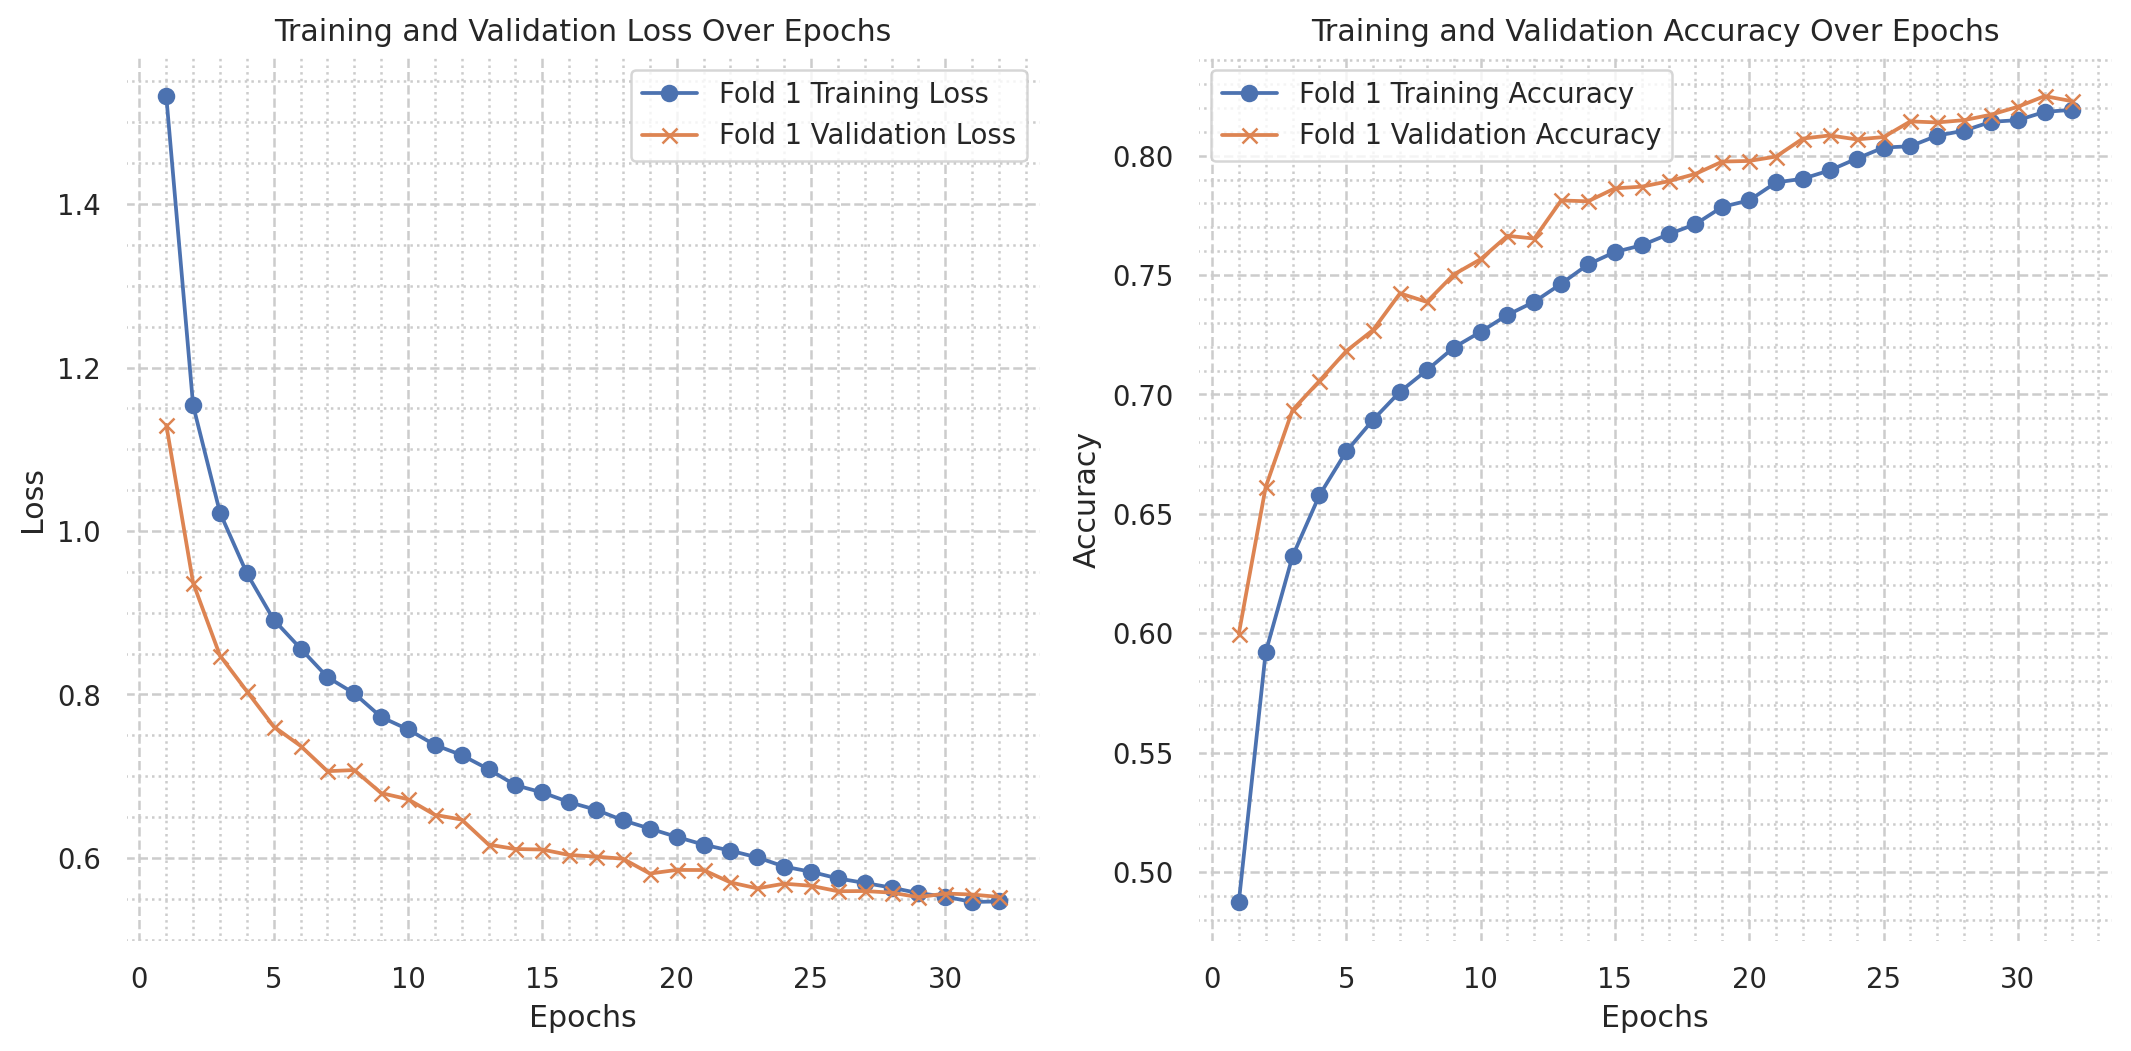


Starting Fold 2/5
Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - accuracy: 0.4388 - loss: 1.7840 - val_accuracy: 0.6209 - val_loss: 1.0957 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5826 - loss: 1.1900 - val_accuracy: 0.6593 - val_loss: 0.9348 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6280 - loss: 1.0421 - val_accuracy: 0.6832 - val_loss: 0.8649 - learning_rate: 0.0010
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6498 - loss: 0.9702 - val_accuracy: 0.7086 - val_loss: 0.7985 - learning_rate: 0.0010
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6773 - loss: 0.8908 - val_accuracy: 0.7222 - val_loss: 0.7583 - learning_rate: 0.0010
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6909 - loss: 0.8487 - val_accuracy: 0.7246 - val_loss: 0.7444 - learning_rate: 0.0010
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - a

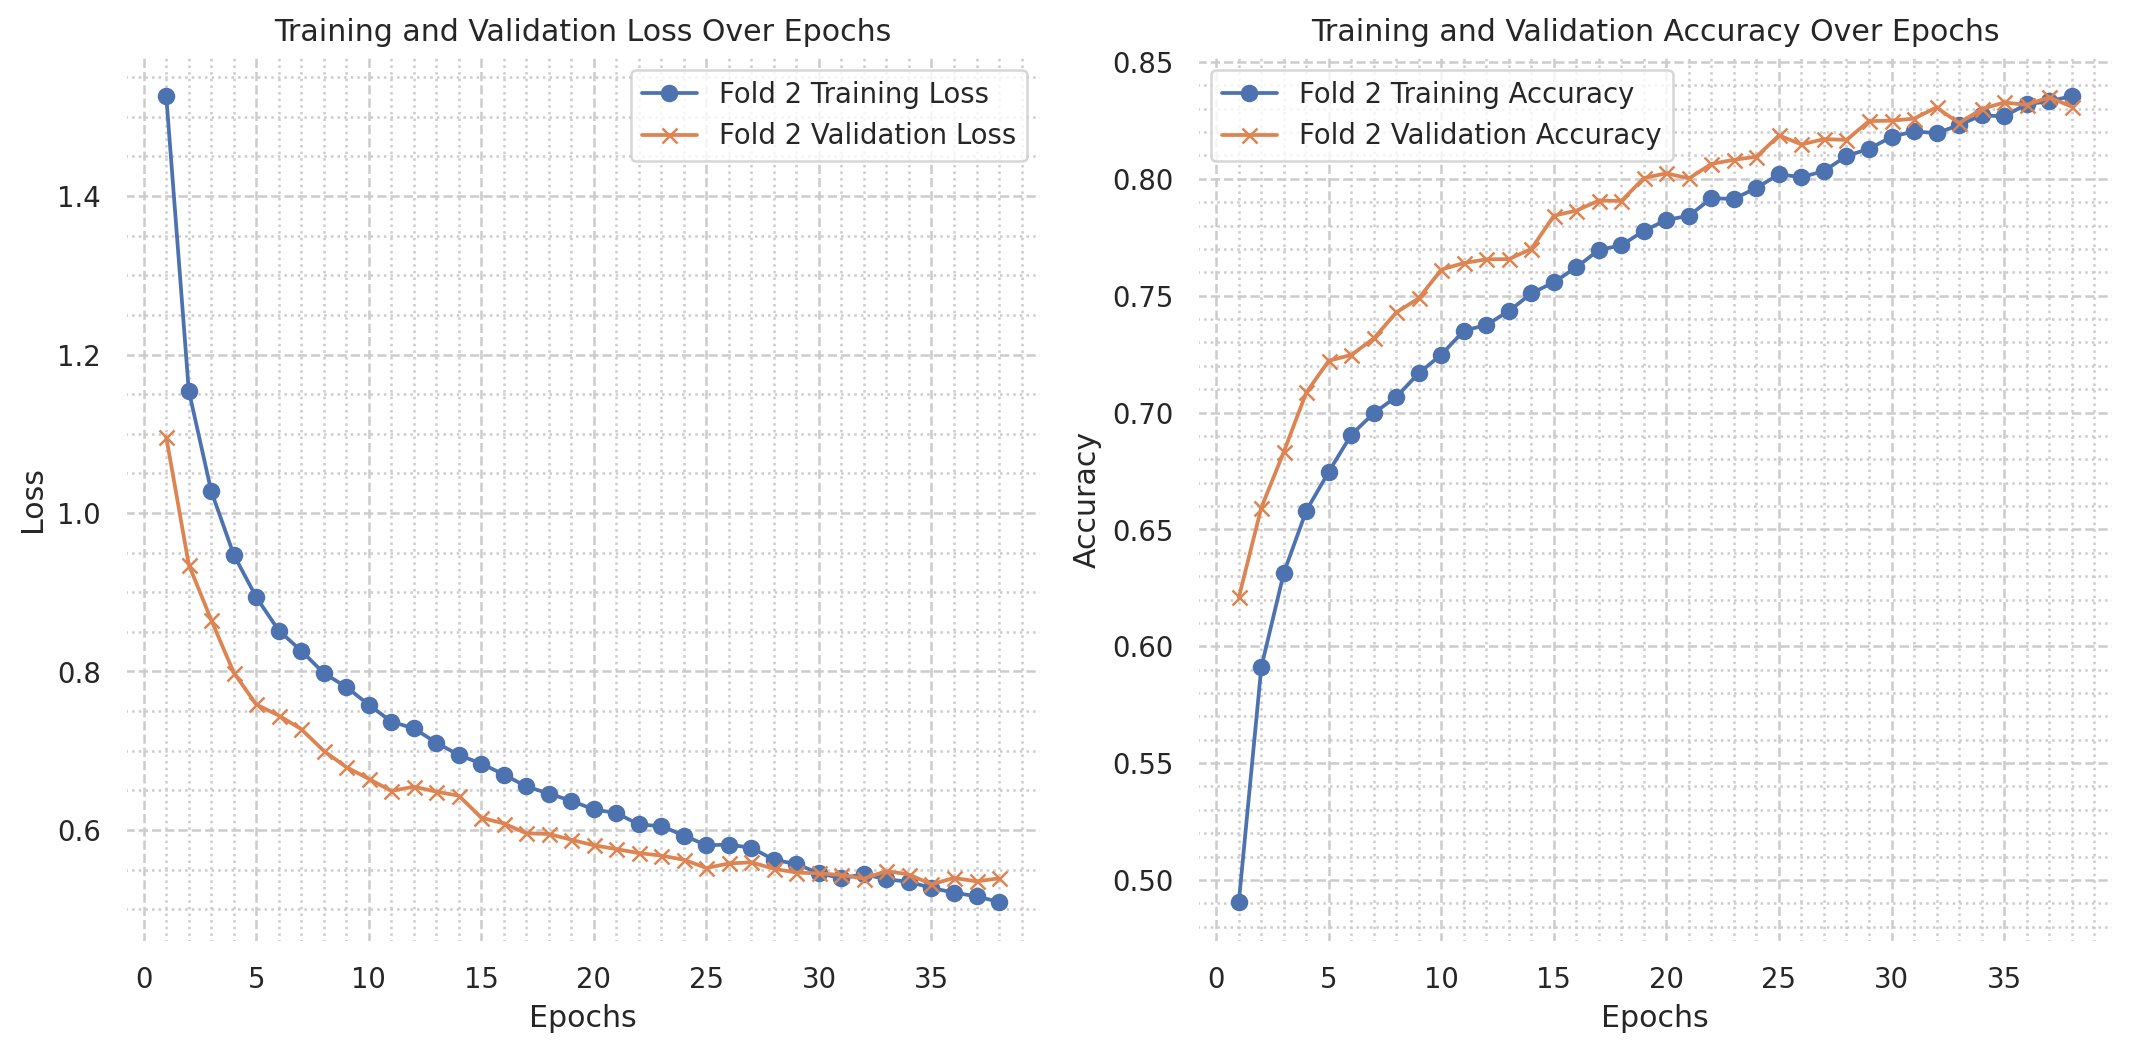


Starting Fold 3/5
Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.4325 - loss: 1.7867 - val_accuracy: 0.6035 - val_loss: 1.1444 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5782 - loss: 1.1955 - val_accuracy: 0.6717 - val_loss: 0.9050 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6323 - loss: 1.0364 - val_accuracy: 0.6878 - val_loss: 0.8505 - learning_rate: 0.0010
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 13ms/step - accuracy: 0.6538 - loss: 0.9615 - val_accuracy: 0.7027 - val_loss: 0.8061 - learning_rate: 0.0010
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6788 - loss: 0.8933 - val_accuracy: 0.7088 - val_loss: 0.7881 - learning_rate: 0.0010
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - accuracy: 0.6903 - loss: 0.8553 - val_accuracy: 0.7259 - val_loss: 0.7460 - learning_rate: 0.0010
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 14ms/step - a

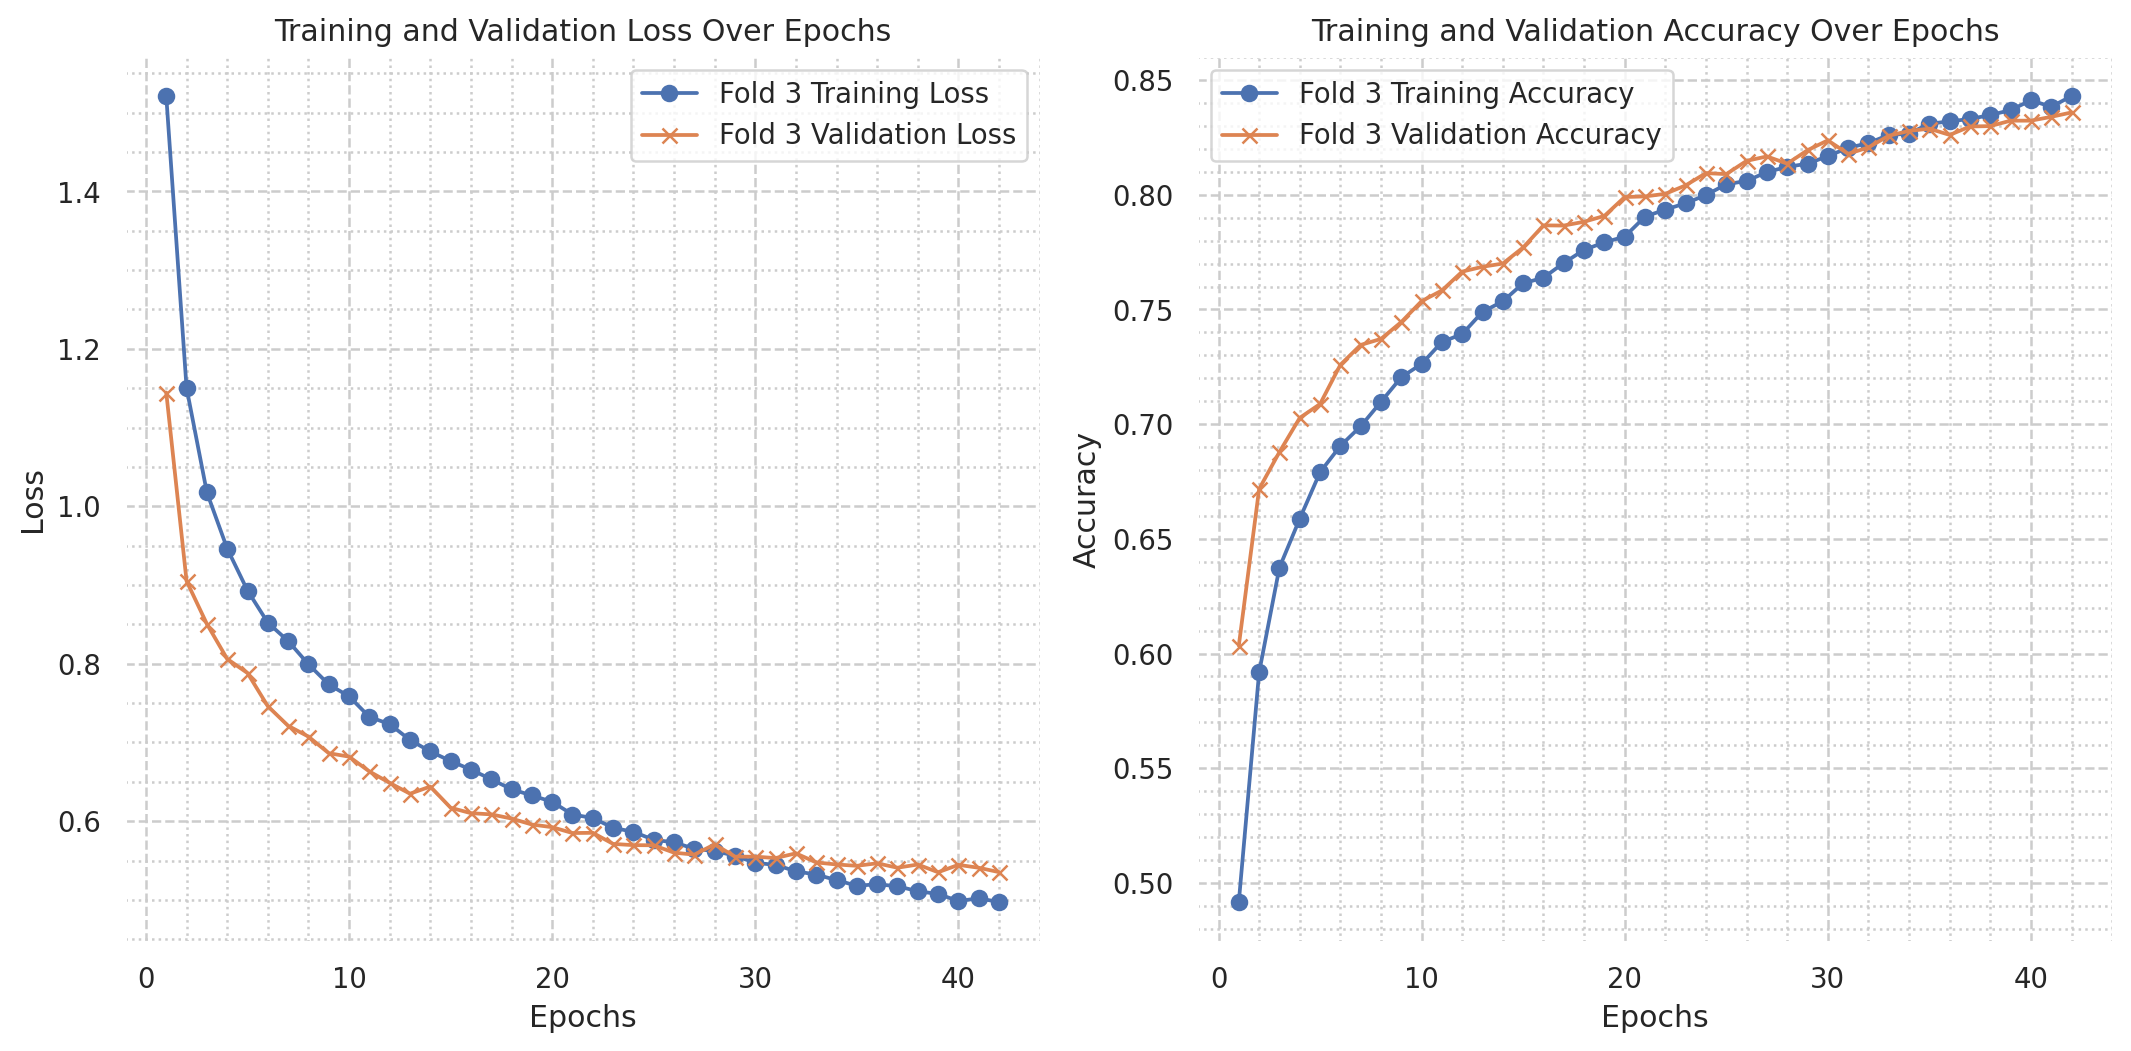


Starting Fold 4/5
Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 10ms/step - accuracy: 0.4318 - loss: 1.7880 - val_accuracy: 0.6059 - val_loss: 1.1331 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5759 - loss: 1.2011 - val_accuracy: 0.6740 - val_loss: 0.9198 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6258 - loss: 1.0463 - val_accuracy: 0.6969 - val_loss: 0.8399 - learning_rate: 0.0010
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6568 - loss: 0.9555 - val_accuracy: 0.7077 - val_loss: 0.7948 - learning_rate: 0.0010
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 5s 15ms/step - accuracy: 0.6712 - loss: 0.9014 - val_accuracy: 0.7283 - val_loss: 0.7547 - learning_rate: 0.0010
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - accuracy: 0.6867 - loss: 0.8713 - val_accuracy: 0.7239 - val_loss: 0.7489 - learning_rate: 0.0010
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - ac

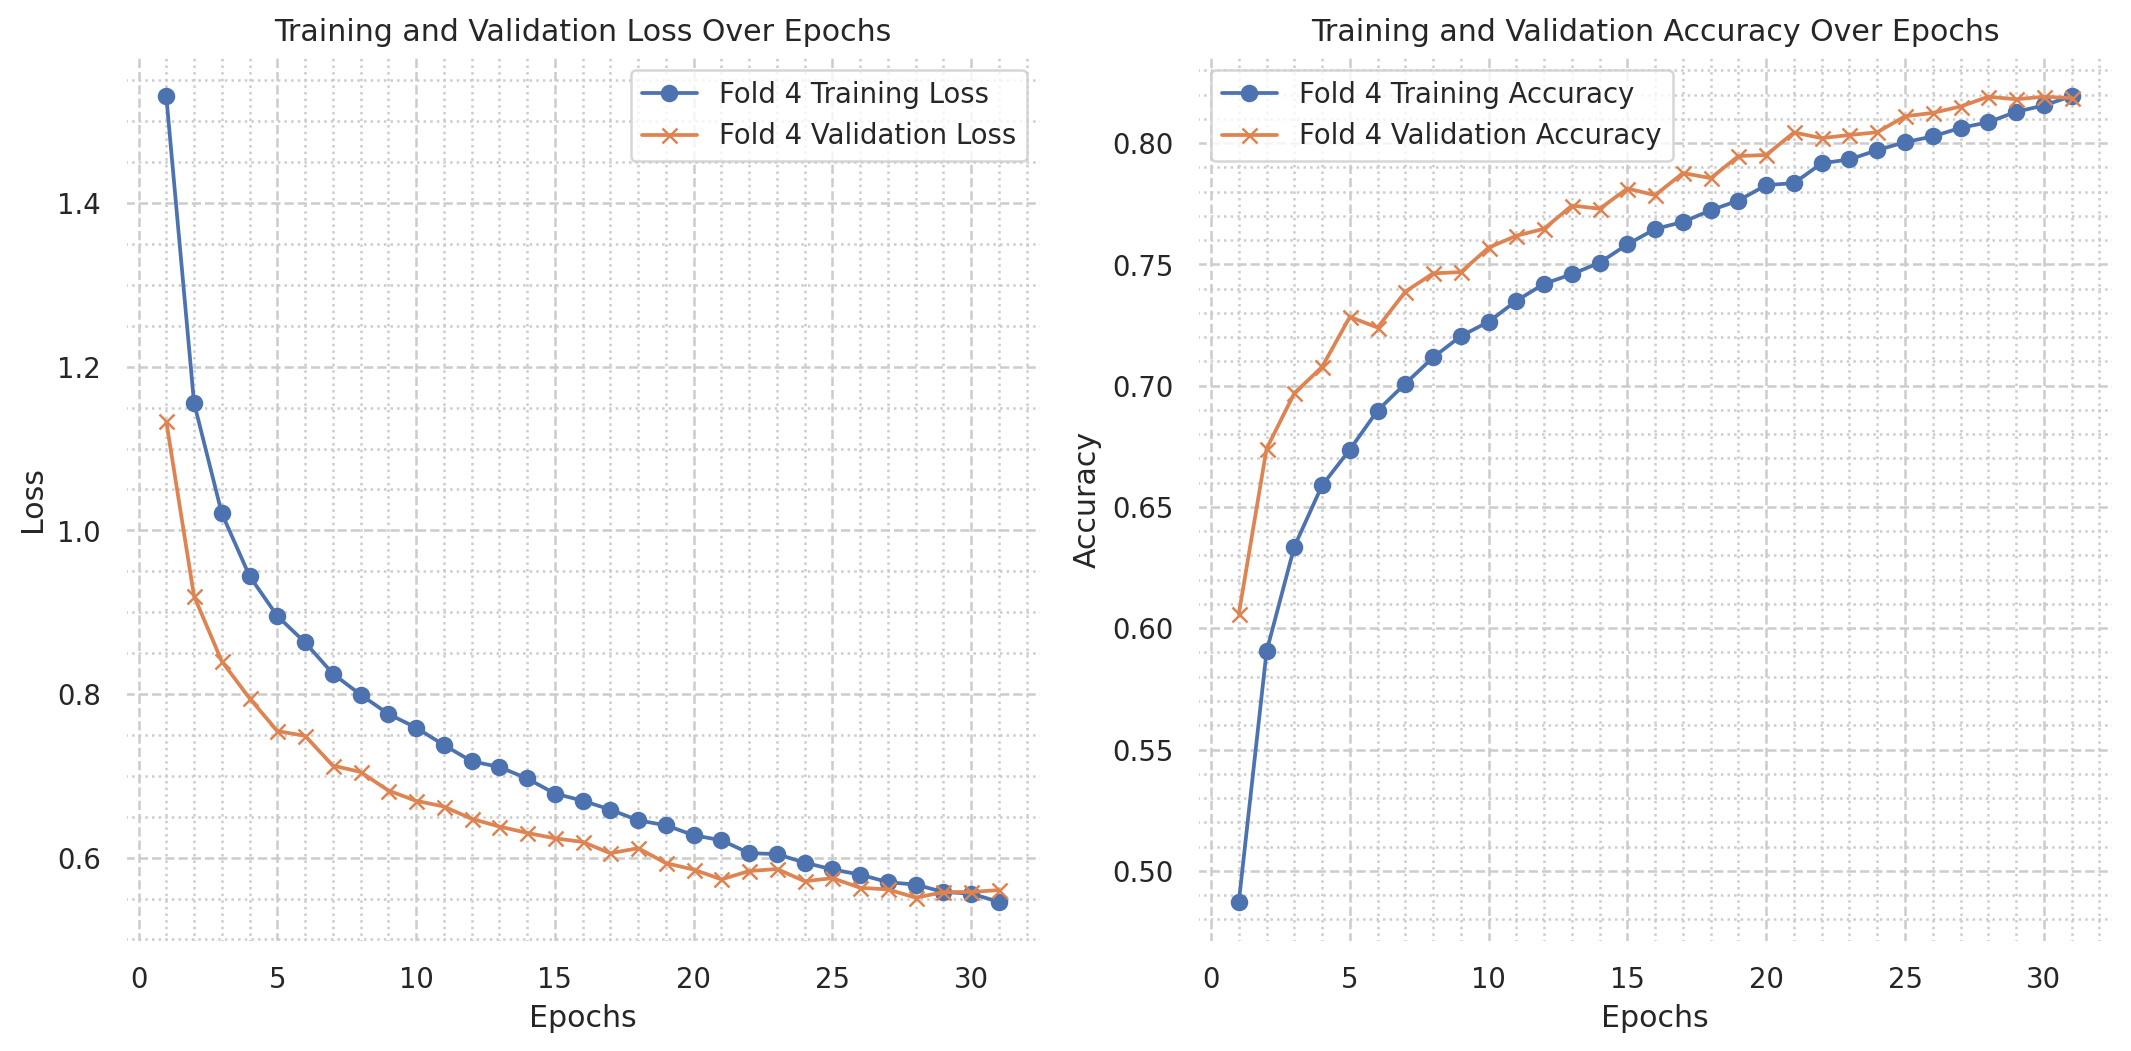


Starting Fold 5/5
Epoch 1/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 6s 11ms/step - accuracy: 0.4422 - loss: 1.7698 - val_accuracy: 0.6071 - val_loss: 1.1182 - learning_rate: 0.0010
Epoch 2/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 10ms/step - accuracy: 0.5787 - loss: 1.1871 - val_accuracy: 0.6638 - val_loss: 0.9320 - learning_rate: 0.0010
Epoch 3/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6275 - loss: 1.0437 - val_accuracy: 0.6917 - val_loss: 0.8494 - learning_rate: 0.0010
Epoch 4/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - accuracy: 0.6592 - loss: 0.9429 - val_accuracy: 0.7009 - val_loss: 0.8136 - learning_rate: 0.0010
Epoch 5/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step - accuracy: 0.6777 - loss: 0.8860 - val_accuracy: 0.7135 - val_loss: 0.7728 - learning_rate: 0.0010
Epoch 6/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.6931 - loss: 0.8536 - val_accuracy: 0.7234 - val_loss: 0.7590 - learning_rate: 0.0010
Epoch 7/100
357/357 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - acc

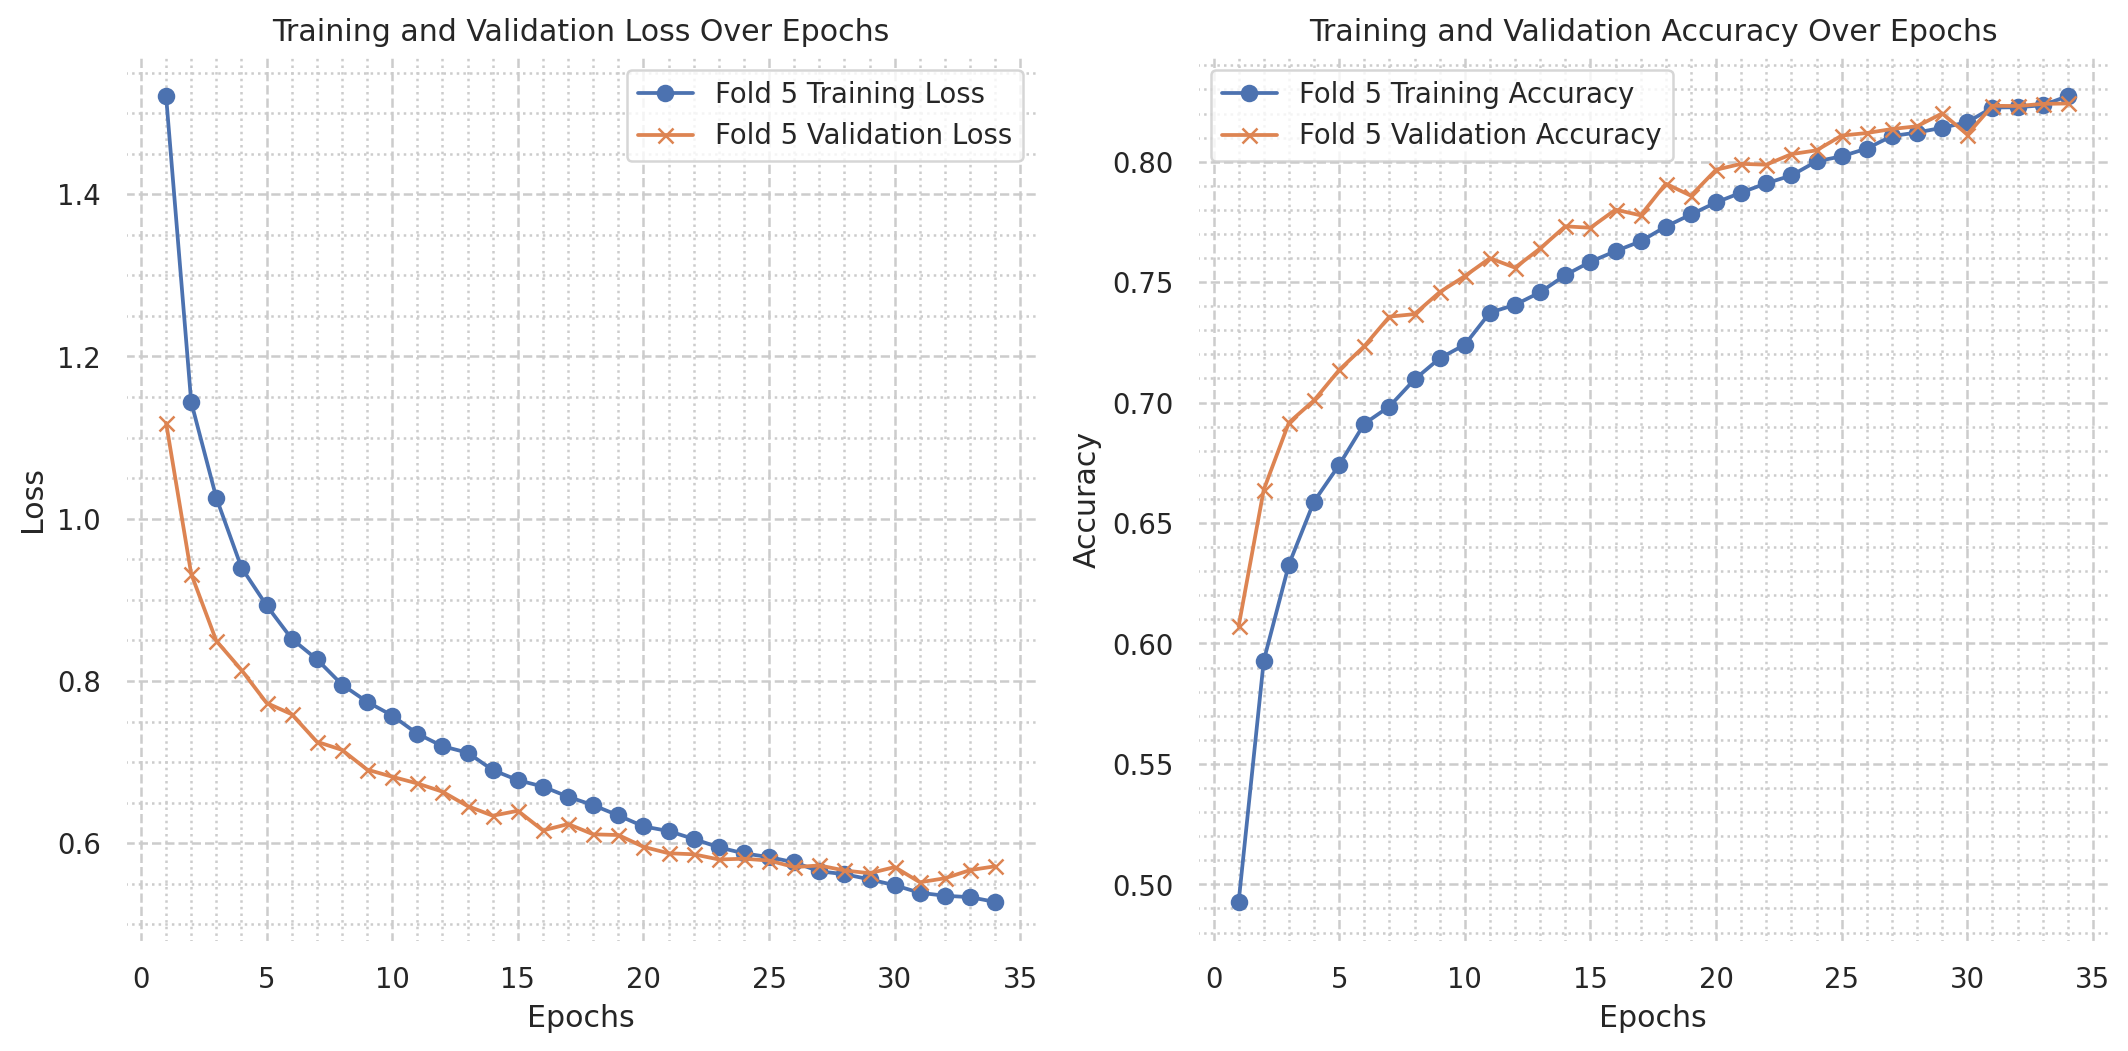


Average Training Loss: 0.5253
Average Validation Loss: 0.5516
Average Training Accuracy: 0.8288
Average Validation Accuracy: 0.8265


In [ ]:
# Import Necessary Libraries
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns
import keras_tuner as kt

# TensorFlow Probability shortcuts
tfd = tfp.distributions
tfpl = tfp.layers

# Set Up Visualizations
plt.rcParams['figure.dpi'] = 180
plt.rcParams["figure.figsize"] = (10, 8)
sns.set_theme(rc={
    'axes.facecolor': '#FFFFFF',
    'figure.facecolor': '#FFFFFF',
    'font.sans-serif': 'DejaVu Sans',
    'font.family': 'sans-serif'
})

#####################################
# Load and Prepare Data
#####################################

# Assuming 'new_merge_df' is already defined and loaded
# For example:
# new_merge_df = pd.read_csv('your_data.csv')
df = new_merge_df.copy()

# Define Categorical and Numerical Features
categorical_features = [
    'quarter', 'down', 'offenseFormation', 'play_type', 
    'defenseFormation', 'pff_manZone', 'game_half', 'is_second_half'
]
numerical_features = [
    'yardsToGo', 'absoluteYardlineNumber', 'average_offense_rating', 
    'average_defense_rating', 'quarter_seconds_remaining', 
    'half_seconds_remaining', 'game_seconds_remaining', 
    'score_differential', 'wp', 'def_wp', 
    'down_yardsToGo', 'quarter_time_ratio', 'half_time_ratio', 
    'posteam_timeout_usage', 'defteam_timeout_usage', 'normalized_down', 
    'normalized_quarter', 'normalized_time_remaining', 'situation_pressure', 
    'goal_to_go', 'blocking_ratio', 'routes_ratio', 'special_actions_ratio', 
    'no_assignment_ratio', 'run_defense_ratio', 'zone_defense_ratio', 
    'man_defense_ratio', 'pass_rush_ratio', 'miscellaneous_ratio', 
    'special_defense_ratio', 'skill_players_count', 'skill_players_ratio',
    'offensive_line_count', 'offensive_line_ratio', 'uncommon_positions_count', 
    'uncommon_positions_ratio', 'defensive_line_count', 'defensive_line_ratio',
    'linebackers_count', 'linebackers_ratio', 'defensive_backs_count', 
    'defensive_backs_ratio', 'non_traditional_count', 'non_traditional_ratio'
]
target = 'yardsGained'

#####################################
# Feature Engineering
#####################################

# Example: Creating an Interaction Feature between 'offenseFormation' and 'defenseFormation'
df['offense_defense_interaction'] = df['offenseFormation'].astype(str) + "_" + df['defenseFormation'].astype(str)
categorical_features.append('offense_defense_interaction')

#####################################
# Encode Categorical Variables as Integers
#####################################

cat_mapping = {}
for cat_col in categorical_features:
    unique_vals = df[cat_col].astype(str).unique()
    cat_mapping[cat_col] = {val: i for i, val in enumerate(unique_vals)}
    df[cat_col] = df[cat_col].astype(str).map(cat_mapping[cat_col])

#####################################
# Scale Numerical Features
#####################################

scaler = StandardScaler()
df[numerical_features] = scaler.fit_transform(df[numerical_features])

X_cats = df[categorical_features].values  # Shape: (N, num_cats)
X_nums = df[numerical_features].values    # Shape: (N, num_numeric)

# Factorize the target variable
y_bins, y_labels = pd.factorize(df[target])

X_combined = np.hstack([X_cats, X_nums])

#####################################
# Handle Class Imbalance with SMOTETomek
#####################################

smote_tomek = SMOTETomek(smote=SMOTE(random_state=512, k_neighbors=1))
X_resampled, y_resampled = smote_tomek.fit_resample(X_combined, y_bins)

X_cats_resampled = X_resampled[:, :X_cats.shape[1]]
X_nums_resampled = X_resampled[:, X_cats.shape[1]:]

num_classes = len(np.unique(y_bins))

# Update Vocabulary Sizes
cat_vocab_sizes = []
for cat_col in categorical_features:
    cat_vocab_sizes.append(len(cat_mapping[cat_col]))

#####################################
# Define Focal Loss
#####################################

def focal_loss_fixed(y_true, y_pred, gamma=2., alpha=.25):
    epsilon = 1e-6
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    cross_entropy = -y_true * tf.math.log(y_pred)
    weight = alpha * tf.math.pow(1 - y_pred, gamma)
    loss = weight * cross_entropy
    return tf.reduce_mean(tf.reduce_sum(loss, axis=1))

#####################################
# Build Enhanced Model
#####################################

def build_enhanced_model(
    cat_vocab_sizes, 
    num_numeric, 
    num_classes, 
    embedding_dim=64,  # Increased embedding dimension
    hidden_units=[512, 512, 512],  # Added more hidden layers with compatible sizes
    dropout_rate=0.3,  # Reduced dropout rate
    l2_reg=1e-5  # Reduced L2 regularization strength
):
    # Categorical Inputs
    cat_input = tf.keras.Input(shape=(len(cat_vocab_sizes),), name="categorical_input", dtype=tf.int32)
    
    # Embedding Layers
    cat_embeddings = []
    for i, vocab_size in enumerate(cat_vocab_sizes):
        embed_layer = tf.keras.layers.Embedding(
            input_dim=vocab_size, 
            output_dim=embedding_dim, 
            name=f"embedding_{i}",
            embeddings_regularizer=tf.keras.regularizers.l2(l2_reg)
        )
        embed_cat = embed_layer(cat_input[:, i])
        cat_embeddings.append(embed_cat)
    
    # Concatenate Embeddings
    cat_emb_concat = tf.keras.layers.Concatenate(axis=1)(cat_embeddings)
    
    # Numerical Inputs
    num_input = tf.keras.Input(shape=(num_numeric,), name="numerical_input", dtype=tf.float32)
    
    # Batch Normalization on Numerical Inputs
    num_normalized = tf.keras.layers.BatchNormalization()(num_input)
    
    # Combine Categorical and Numerical Features
    combined = tf.keras.layers.Concatenate()([cat_emb_concat, num_normalized])
    
    # First Hidden Layer
    x = tf.keras.layers.Dense(hidden_units[0], kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(combined)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('tanh')(x)  # Advanced Activation Function
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Second Hidden Layer
    x = tf.keras.layers.Dense(hidden_units[1], kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Third Hidden Layer with Residual Connection
    x_prev = x
    x = tf.keras.layers.Dense(hidden_units[2], kernel_regularizer=tf.keras.regularizers.l2(l2_reg))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    
    # Residual Connection
    x = tf.keras.layers.Add()([x, x_prev])
    
    # Output Layer
    logits = tf.keras.layers.Dense(num_classes, kernel_regularizer=tf.keras.regularizers.l2(l2_reg), name="output")(x)
    
    # Softmax Activation
    probabilities = tf.keras.layers.Activation('softmax')(logits)
    
    # Define the Model
    model = tf.keras.Model(inputs=[cat_input, num_input], outputs=probabilities)
    return model

#####################################
# Plot Training and Validation Metrics
#####################################

def plot_training_validation_metrics(train_losses, val_losses, train_accuracies, val_accuracies, fold):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 6))
    
    # Plot Training and Validation Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label=f'Fold {fold} Training Loss', marker='o')
    plt.plot(epochs, val_losses, label=f'Fold {fold} Validation Loss', marker='x')
    plt.title('Training and Validation Loss Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(which='major', color='#CCCCCC', linestyle='--')
    plt.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.minorticks_on()
    
    # Plot Training and Validation Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label=f'Fold {fold} Training Accuracy', marker='o')
    plt.plot(epochs, val_accuracies, label=f'Fold {fold} Validation Accuracy', marker='x')
    plt.title('Training and Validation Accuracy Over Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(which='major', color='#CCCCCC', linestyle='--')
    plt.grid(which='minor', color='#CCCCCC', linestyle=':')
    plt.minorticks_on()
    
    plt.tight_layout()
    plt.show()


class EarlyStoppingByLossThreshold(tf.keras.callbacks.Callback):
    def __init__(self, monitor='val_loss', threshold=0.1, patience=3):
        super(EarlyStoppingByLossThreshold, self).__init__()
        self.monitor = monitor
        self.threshold = threshold
        self.patience = patience
        self.wait = 0

    def on_epoch_end(self, epoch, logs=None):
        current = logs.get(self.monitor)
        if current is None:
            print(f"EarlyStoppingByLossThreshold requires {self.monitor} available!")
            return

        if current <= self.threshold:
            self.wait += 1
            print(f"Epoch {epoch+1}: {self.monitor} is below {self.threshold} (count: {self.wait}/{self.patience})")
            if self.wait >= self.patience:
                print(f"\nEarly stopping triggered. {self.monitor} has been below {self.threshold} for {self.patience} consecutive epochs.")
                self.model.stop_training = True
        else:
            if self.wait > 0:
                print(f"Epoch {epoch+1}: {self.monitor} has risen above {self.threshold}. Resetting patience counter.")
            self.wait = 0


#####################################
# Training Parameters
#####################################

batch_size = 128
n_splits = 5
num_epochs = 100 # Increased from 100 to 200
early_stopping_patience = 3  # Increased patience

#####################################
# Prepare Data for Cross-Validation
#####################################

X_res_cat = X_cats_resampled
X_res_num = X_nums_resampled

# One-hot encode the labels for categorical crossentropy
y_resampled_categorical = tf.keras.utils.to_categorical(y_resampled, num_classes=num_classes)

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)

all_fold_train_losses = []
all_fold_val_losses = []
all_fold_train_accuracies = []
all_fold_val_accuracies = []


#####################################
# K-Fold Cross-Validation Loop with model.fit and Callbacks
#####################################

for fold, (train_index, val_index) in enumerate(skf.split(X_res_cat, y_resampled), start=1):
    print(f"\nStarting Fold {fold}/{n_splits}")
    
    # Split data into training and validation sets for this fold
    X_train_fold_cat, X_val_cat = X_res_cat[train_index], X_res_cat[val_index]
    X_train_fold_num, X_val_num = X_res_num[train_index], X_res_num[val_index]
    y_train_fold, y_val_fold = y_resampled_categorical[train_index], y_resampled_categorical[val_index]

    # Build a fresh model for each fold
    model = build_enhanced_model(
        cat_vocab_sizes=cat_vocab_sizes,
        num_numeric=len(numerical_features),
        num_classes=num_classes,  # Reduced dropout
        l2_reg=1e-5  # Reduced L2 regularization
    )
    
    # Compile the model with Nadam optimizer and categorical crossentropy
    optimizer = tf.keras.optimizers.Nadam(learning_rate=0.001)
    model.compile(
        optimizer=optimizer,
        loss='categorical_crossentropy',  # Or use focal_loss_fixed
        metrics=['accuracy']
    )
    
    # Define Callbacks
    early_stop = tf.keras.callbacks.EarlyStopping(
        monitor='val_loss', 
        patience=early_stopping_patience, 
        restore_best_weights=True
    )
    
    lr_reduce = tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        factor=0.5, 
        patience=5, 
        min_lr=1e-6
    )
    
    # Custom Early Stopping Callback
    custom_early_stop = EarlyStoppingByLossThreshold(
        monitor='val_loss',  # Monitor training loss
        threshold=0.1,   # Define an appropriate threshold based on your data
        patience=3        # Number of consecutive epochs below threshold to stop
    )
    
    # List of Callbacks
    callbacks = [early_stop, lr_reduce, custom_early_stop]
    
    # Fit the Model
    history = model.fit(
        x={'categorical_input': X_train_fold_cat, 'numerical_input': X_train_fold_num},
        y=y_train_fold,
        validation_data=(
            {'categorical_input': X_val_cat, 'numerical_input': X_val_num},
            y_val_fold
        ),
        epochs=num_epochs,
        batch_size=batch_size,
        callbacks=callbacks,
        verbose=1
    )
    
    # Evaluate the Model on Validation Data
    val_loss, val_accuracy = model.evaluate(
        {'categorical_input': X_val_cat, 'numerical_input': X_val_num},
        y_val_fold,
        verbose=0
    )
    
    print(f"Fold {fold} Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.4f}")
    
    # Plot Metrics for This Fold
    plot_training_validation_metrics(
        history.history['loss'], 
        history.history['val_loss'], 
        history.history['accuracy'], 
        history.history['val_accuracy'], 
        fold
    )
    
    # Store Fold Metrics
    all_fold_train_losses.append(history.history['loss'][-1])
    all_fold_val_losses.append(history.history['val_loss'][-1])
    all_fold_train_accuracies.append(history.history['accuracy'][-1])
    all_fold_val_accuracies.append(history.history['val_accuracy'][-1])

#####################################
# Report Final Metrics Across Folds
#####################################

print(f"\nAverage Training Loss: {np.mean(all_fold_train_losses):.4f}")
print(f"Average Validation Loss: {np.mean(all_fold_val_losses):.4f}")
print(f"Average Training Accuracy: {np.mean(all_fold_train_accuracies):.4f}")
print(f"Average Validation Accuracy: {np.mean(all_fold_val_accuracies):.4f}")


In [30]:
# Import Necessary Libraries
import os
import json
import joblib
# Define a directory to save models and components
save_dir = 'tensorflow_models/final_yards_gained_preds'
os.makedirs(save_dir, exist_ok=True)
print(f"Directory '{save_dir}' is ready for saving models and components.")

# Define the path to save the model
model_file = os.path.join(save_dir, 'yard_gained_model.keras')

# Save the trained TensorFlow/Keras model format
model.save(model_file)
print(f"TensorFlow model saved successfully as {model_file}.")

# Path to save cat_mapping
cat_mapping_file = os.path.join(save_dir, 'cat_mapping.json')

# Save cat_mapping to a JSON file
with open(cat_mapping_file, 'w') as f:
    json.dump(cat_mapping, f)
print(f"Categorical mapping saved successfully as {cat_mapping_file}.")

# Path to save the scaler
scaler_file = os.path.join(save_dir, 'scaler.joblib')

# Save the scaler using joblib
joblib.dump(scaler, scaler_file)
print(f"Scaler saved successfully as {scaler_file}.")

# Path to save y_labels
y_labels_file = os.path.join(save_dir, 'y_labels.json')

# Save y_labels to a JSON file
with open(y_labels_file, 'w') as f:
    json.dump(y_labels.tolist(), f)
print(f"Y-labels saved successfully as {y_labels_file}.")

Directory 'tensorflow_models/final_yards_gained_preds' is ready for saving models and components.
TensorFlow model saved successfully as tensorflow_models/final_yards_gained_preds/yard_gained_model.keras.
Categorical mapping saved successfully as tensorflow_models/final_yards_gained_preds/cat_mapping.json.
Scaler saved successfully as tensorflow_models/final_yards_gained_preds/scaler.joblib.
Y-labels saved successfully as tensorflow_models/final_yards_gained_preds/y_labels.json.


In [ ]:
# Load the trained model
model_file = os.path.join(save_dir, 'yard_gained_model.keras')
model = tf.keras.models.load_model(model_file, compile=False, custom_objects={'focal_loss_fixed': focal_loss_fixed})
print(f"Model loaded successfully from {model_file} without compiling.")

# Load cat_mapping
cat_mapping_file = os.path.join(save_dir, 'cat_mapping.json')
with open(cat_mapping_file, 'r') as f:
    cat_mapping = json.load(f)
print(f"Categorical mapping loaded from {cat_mapping_file}.")

# Load the scaler
scaler_file = os.path.join(save_dir, 'scaler.joblib')
scaler = joblib.load(scaler_file)
print(f"Scaler loaded from {scaler_file}.")

# Load y_labels
y_labels_file = os.path.join(save_dir, 'y_labels.json')
with open(y_labels_file, 'r') as f:
    y_labels = json.load(f)
print(f"Y-labels loaded from {y_labels_file}.")


def predict_yard_bins_sorted(game_scenario, model, cat_features, cat_mapping, numerical_features, scaler, y_labels):
    # Create a DataFrame for the single game scenario
    scenario_df = pd.DataFrame([game_scenario])
    
    # Convert categorical features using cat_mapping
    for cat_col in cat_features:
        scenario_df[cat_col] = scenario_df[cat_col].astype(str).map(cat_mapping[cat_col])
    
    # Handle possible unseen categories by assigning a default index (e.g., 'unknown' or 0)
    for cat_col in cat_features:
        if scenario_df[cat_col].isnull().any():
            # Assign 'unknown' index if defined, else use 0
            unknown_index = cat_mapping[cat_col].get('unknown', 0)
            scenario_df[cat_col] = scenario_df[cat_col].fillna(unknown_index).astype(int)
    
    # Scale numerical features
    scenario_df[numerical_features] = scaler.transform(scenario_df[numerical_features])
    
    # Separate categorical and numerical data
    X_cat = scenario_df[cat_features].values  # shape: (1, num_cats)
    X_num = scenario_df[numerical_features].values  # shape: (1, num_numeric)

    # Convert to tensors with appropriate data types
    X_cat_tensor = tf.convert_to_tensor(X_cat, dtype=tf.int32)
    X_num_tensor = tf.convert_to_tensor(X_num, dtype=tf.float32)

    # Predict probabilities by passing inputs as a list
    y_pred = model([X_cat_tensor, X_num_tensor], training=False)
    
    # Extract probabilities
    probabilities = y_pred.numpy()[0]

    # Create a dictionary and sort by probability in descending order
    bin_probs = {y_labels[i]: float(prob) for i, prob in enumerate(probabilities)}
    sorted_bin_probs = dict(sorted(bin_probs.items(), key=lambda item: item[1], reverse=True))
    
    return sorted_bin_probs

def convert_numpy_types(obj):
    if isinstance(obj, np.generic):
        return obj.item()  # Convert NumPy scalars to Python scalars
    raise TypeError(f"Object of type {type(obj).__name__} is not JSON serializable")

mynew_df = filtered_df_9

merged_df_new = pd.merge(
    mynew_df,
    pbp_2022,
    left_on=['gameId', 'playId'],
    right_on=['old_game_id', 'play_id'],
    how='inner'
)


# Interaction Feature
merged_df_new['down_yardsToGo'] = merged_df_new['down'] * merged_df_new['yardsToGo']

# Time Remaining Ratios
merged_df_new['quarter_time_ratio'] = merged_df_new['quarter_seconds_remaining'] / 900
merged_df_new['half_time_ratio'] = merged_df_new['half_seconds_remaining'] / 1800

# Normalized Score Differential
total_score = merged_df_new['posteam_score'] + merged_df_new['defteam_score']
merged_df_new['normalized_score_differential'] = merged_df_new['score_differential'] / total_score

# Timeout Usage Features
merged_df_new['posteam_timeout_usage'] = (3 - merged_df_new['posteam_timeouts_remaining']) / 3
merged_df_new['defteam_timeout_usage'] = (3 - merged_df_new['defteam_timeouts_remaining']) / 3

# Game Half Indicator
merged_df_new['is_second_half'] = (merged_df_new['game_half'] == 'Half2').astype(int)

import pandas as pd

# Assuming 'df' is your DataFrame

# Normalize Down (1st = 0.25, 2nd = 0.50, 3rd = 0.75, 4th = 1.00)
merged_df_new['normalized_down'] = merged_df_new['down'] / 4

# Normalize Quarter (1st = 0.25, ..., 4th = 1.00)
merged_df_new['normalized_quarter'] = merged_df_new['quarter'] / 4

# Normalize Remaining Time (assuming max time is in seconds for a quarter)
max_time_quarter = 900  # total seconds in a quarter
merged_df_new['normalized_time_remaining'] = merged_df_new['quarter_seconds_remaining'] / max_time_quarter

# Create Situation Pressure Feature
merged_df_new['situation_pressure'] = (
    merged_df_new['normalized_down'] +
    merged_df_new['normalized_quarter'] +
    merged_df_new['normalized_time_remaining']
) / 3

merged_df_new['offense_defense_interaction'] = merged_df_new['offenseFormation'].astype(str) + "_" + merged_df_new['defenseFormation'].astype(str)

# One-Hot Encoding for categorical variables (example for offenseFormation)
# df = pd.get_dummies(merged_df, columns=['offenseFormation', 'defenseFormation', 'play_type'], drop_first=True)

# Get all the game scenarios for unseen data
game_scenarios = []
for _, row in merged_df_new.iterrows():
    game_scenario = {
        'quarter': row['quarter'],
        'down': row['down'],
        'yardsToGo': row['yardsToGo'],
        'absoluteYardlineNumber': row['absoluteYardlineNumber'],
        'offenseFormation': row['offenseFormation'],
        'play_type': row['play_type'],
        'defenseFormation': row['defenseFormation'],
        'pff_manZone': row['pff_manZone'],
        'average_offense_rating': row['average_offense_rating'],
        'average_defense_rating': row['average_defense_rating'],
        'blocking_ratio': row['blocking_ratio'],
        'routes_ratio': row['routes_ratio'],
        'special_actions_ratio': row['special_actions_ratio'],
        'no_assignment_ratio': row['no_assignment_ratio'],
        'run_defense_ratio': row['run_defense_ratio'],
        'zone_defense_ratio': row['zone_defense_ratio'],
        'man_defense_ratio': row['man_defense_ratio'],
        'pass_rush_ratio': row['pass_rush_ratio'],
        'miscellaneous_ratio': row['miscellaneous_ratio'],
        'special_defense_ratio': row['special_defense_ratio'],
        'skill_players_count': row['skill_players_count'],
        'skill_players_ratio': row['skill_players_ratio'],
        'offensive_line_count': row['offensive_line_count'],
        'offensive_line_ratio': row['offensive_line_ratio'],
        'uncommon_positions_count': row['uncommon_positions_count'],
        'uncommon_positions_ratio': row['uncommon_positions_ratio'],
        'defensive_line_count': row['defensive_line_count'],
        'defensive_line_ratio': row['defensive_line_ratio'],
        'linebackers_count': row['linebackers_count'],
        'linebackers_ratio': row['linebackers_ratio'],
        'defensive_backs_count': row['defensive_backs_count'],
        'defensive_backs_ratio': row['defensive_backs_ratio'],
        'non_traditional_count': row['non_traditional_count'],
        'non_traditional_ratio': row['non_traditional_ratio'],
        'quarter_seconds_remaining': row['quarter_seconds_remaining'],
        'half_seconds_remaining': row['half_seconds_remaining'],
        'game_seconds_remaining': row['game_seconds_remaining'],
        'game_half': row['game_half'],
        'goal_to_go': row['goal_to_go'],
        'score_differential': row['score_differential'],
        'wp': row['wp'],
        'def_wp': row['def_wp'],
        'down_yardsToGo': row['down_yardsToGo'],
        'quarter_time_ratio': row['quarter_time_ratio'],
        'half_time_ratio': row['half_time_ratio'],
        'posteam_timeout_usage': row['posteam_timeout_usage'],
        'defteam_timeout_usage': row['defteam_timeout_usage'],
        'is_second_half': row['is_second_half'],
        'normalized_down': row['normalized_down'],
        'normalized_quarter': row['normalized_quarter'],
        'normalized_time_remaining': row['normalized_time_remaining'],
        'situation_pressure': row['situation_pressure'],
        'offense_defense_interaction': row['offense_defense_interaction']
    }
    game_scenarios.append(game_scenario)

# Print the extracted game_scenarios
# for i, scenario in enumerate(game_scenarios, 1):
#     print(f"Game Scenario {i}: {scenario}")


import numpy as np
import json  # Ensure this is imported if you intend to use JSON formatting in print statements

# Initialize counters
match_count = 0
mismatch_count = 0
perfect_match_count = 0
top2_match_count = 0  # New Counter for Top 2 Matches
total_scenarios = len(game_scenarios)

# Loop through each game scenario and get predictions
# Note: Starting enumeration from 1 for clarity unless there's a specific reason to start from 11
for i, (game_scenario, actual_yards) in enumerate(zip(game_scenarios, merged_df_new['yardsGained']), start=1):
    bin_probabilities = predict_yard_bins_sorted(
        game_scenario=game_scenario, 
        model=model, 
        cat_features=categorical_features, 
        cat_mapping=cat_mapping, 
        numerical_features=numerical_features, 
        scaler=scaler, 
        y_labels=y_labels
    )
    
    # Get the top 3 and top 2 predicted bins and the top predicted bin
    sorted_bins = list(bin_probabilities.keys())  # Assuming bin_probabilities are sorted in descending order
    top_3_bins = sorted_bins[:3]
    top_2_bins = sorted_bins[:2]  # New: Top 2 bins
    top_bin = sorted_bins[0]
    
    # Check for match (actual yards in top 3 bins)
    if actual_yards in top_3_bins:
        match_count += 1
        
        # Check if it's a perfect match (actual yards is the top predicted bin)
        if actual_yards == top_bin:
            perfect_match_count += 1
    else:
        mismatch_count += 1
        # Optionally, log or store mismatches if needed
    
    # New: Check for Top 2 match (actual yards in top 2 bins)
    if actual_yards in top_2_bins:
        top2_match_count += 1
    
    # Optional: Print scenario details for debugging
    # print(f"Scenario {i}:")
    # print(f"Predicted Yard Bin Probabilities: {json.dumps(bin_probabilities, indent=4, default=convert_numpy_types)}")
    # print(f"Actual Yards Gained: {actual_yards}")
    # print(f"Top 3 Predicted Bins: {top_3_bins}")
    # print(f"Top 2 Predicted Bins: {top_2_bins}") 
    # print(f"Top Predicted Bin: {top_bin}\n")

# Calculate percentages
match_percentage = (match_count / total_scenarios) * 100
mismatch_percentage = (mismatch_count / total_scenarios) * 100
perfect_match_percentage = (perfect_match_count / total_scenarios) * 100
top2_match_percentage = (top2_match_count / total_scenarios) * 100 

# Print overall results
print(f"\nTotal Scenarios: {total_scenarios}")
print(f"Total Matches (Actual Yards in Top 3 Predictions): {match_count} ({match_percentage:.2f}%)")
print(f"Total Top 2 Matches (Actual Yards in Top 2 Predictions): {top2_match_count} ({top2_match_percentage:.2f}%)")  # New
print(f"Total Perfect Matches (Actual Yards as Top Prediction): {perfect_match_count} ({perfect_match_percentage:.2f}%)")
print(f"Total Mismatches: {mismatch_count} ({mismatch_percentage:.2f}%)")



Model loaded successfully from tensorflow_models/final_yards_gained_preds/yard_gained_model.keras without compiling.
Categorical mapping loaded from tensorflow_models/final_yards_gained_preds/cat_mapping.json.
Scaler loaded from tensorflow_models/final_yards_gained_preds/scaler.joblib.
Y-labels loaded from tensorflow_models/final_yards_gained_preds/y_labels.json.

Total Scenarios: 1535
Total Matches (Actual Yards in Top 3 Predictions): 1416 (92.25%)
Total Top 2 Matches (Actual Yards in Top 2 Predictions): 1277 (83.19%)
Total Perfect Matches (Actual Yards as Top Prediction): 969 (63.13%)
Total Mismatches: 119 (7.75%)
